# Caso Practico: ((1)) Predecir el consumo de los vehículos

In [ ]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



### Importación de CSV

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1uVyq1fLWfeJ8Omw9wQq4v7D-FZpStRtM'})

In [ ]:
fileDownloaded.GetContentFile('csv_auto.csv')


In [ ]:
import pandas as pd
df_auto = pd.read_csv('csv_auto.csv', delimiter=',' )

#df_auto.head()
df_auto.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531,23.445918
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518,7.805007
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,17.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,22.750000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [ ]:
fileDownloaded = drive.CreateFile({'id':'1HxdCEfpXL65qCRh0pMlryHnZOKPkTtHt'})
fileDownloaded.GetContentFile('csv_crime_data.csv')

# Random Forests

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

import multiprocessing

In [ ]:
datos = df_auto

datos.head(10)

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,8,307.0,130.0,3504.0,12.0,70,1,18.0
1,8,350.0,165.0,3693.0,11.5,70,1,15.0
2,8,318.0,150.0,3436.0,11.0,70,1,18.0
3,8,304.0,150.0,3433.0,12.0,70,1,16.0
4,8,302.0,140.0,3449.0,10.5,70,1,17.0
5,8,429.0,198.0,4341.0,10.0,70,1,15.0
6,8,454.0,220.0,4354.0,9.0,70,1,14.0
7,8,440.0,215.0,4312.0,8.5,70,1,14.0
8,8,455.0,225.0,4425.0,10.0,70,1,14.0
9,8,390.0,190.0,3850.0,8.5,70,1,15.0


In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     392 non-null    int64  
 1   displacement  392 non-null    float64
 2   horsepower    392 non-null    float64
 3   weight        392 non-null    float64
 4   acceleration  392 non-null    float64
 5   model_year    392 non-null    int64  
 6   origin        392 non-null    int64  
 7   mpg           392 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 24.6 KB


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "mpg"),
                                        datos['mpg'],
                                        random_state = 123
                                    )

print("x_train %s :: y_train %s :: x_test %s :: y_test %s" %( str(x_train.shape), str(y_train.shape), str(x_test.shape), str(y_test.shape) ) )

# Creación del modelo
# ==============================================================================
modelo_rfr = RandomForestRegressor(
            n_estimators = 10           #número de árboles usados dentro del modelo
            , criterion    = 'squared_error'      #MSE:: Error Cuadratico Medio. Para medir la calidad de las divisiones(split:: es una variable (atributo) +  una lista de condiciones sobre la variable)
            , max_depth    = None                 #La profundidad máxima del árbol. Si es Ninguno, los nodos se expanden hasta alguna hoja
            , max_features = 'auto'     #El número de características a considerar al buscar la mejor división
            , oob_score    = False      #r2 para los datos test que se generan internamento en el modelo. Por defecto es False ya que aumenta el tiempo de entrenamiento
            , n_jobs       = -1         #El número de jobs que se ejecutan en paralelo. En random forest los árboles se ajustan de forma independiente, por la paralelización reduce notablemente el tiempo de entrenamiento. 
                                        #Con -1 se utilizan todos los cores disponibles
            , random_state = 123        #Semilla para que los resultados sean reproducibles. Tiene que ser un valor entero
         )

# Entrenamiento del modelo
# ==============================================================================
modelo_rfr.fit(x_train, y_train)


x_train (294, 7) :: y_train (294,) :: x_test (98, 7) :: y_test (98,)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
y_test_pred = modelo_rfr.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_test_pred,
        squared = False
       )

#RMSE es más sensible a las observaciones que están más lejos de la media
print(f"El Error cuadrático medio (rmse) de test es: {rmse}")  #Las predicciones del modelo final se alejan en promedio 3.22 mpg del valor real
print('R^2', r2_score(y_true = y_test, y_pred = y_test_pred))
print('Error absoluto medio de test es: ', mean_absolute_error(y_test_pred, y_test))  ##Las predicciones del modelo final se alejan en promedio 2.14 mpg del valor real


El Error cuadrático medio (rmse) de test es: 3.2778405659077143
R^2 0.816360093689612
Error absoluto medio de test es:  2.1412244897959183


In [ ]:
#Ejemplos de Obtención de estimaciones
#cylinders	displacement	horsepower	weight	acceleration	model_year	origin
x_ejem_1 = np.array([[4, 119, 80, 3000, 17, 73, 2]] )
print('Ejemplo Estimacion (1):', modelo_rfr.predict( x_ejem_1 ))

x_ejem_2 = np.array([[6, 116, 83, 2700, 21, 70, 3]] )
print('Ejemplo Estimacion (2):', modelo_rfr.predict( x_ejem_2 ))

x_ejem = np.concatenate( (x_ejem_1, x_ejem_2 ) )


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


Ejemplo Estimacion (1): [22.1]
Ejemplo Estimacion (2): [21.48]


In [ ]:
#####################################################
##Importancia de las variables Independientes
#####################################################
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "mpg").columns,
                             'importancia': modelo_rfr.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,displacement,0.539711
0,cylinders,0.130455
5,model_year,0.118284
2,horsepower,0.092198
3,weight,0.082214
4,acceleration,0.035101
6,origin,0.002038


In [ ]:
## Medimos la importancia de una característica calculando el aumento en el error de predicción del modelo después de permutar la característica.
## Una característica es “importante” si cambiar sus valores aumenta el error del modelo, porque en este caso el modelo se basó en la característica para la predicción. 
## Una característica es “no importante” si cambiar sus valores deja el error del modelo sin cambios, porque en este caso el modelo ignoró la característica para la predicción
importancia = permutation_importance(
                estimator    = modelo_rfr,
                X            = x_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = x_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
1,4.302349,0.195166,displacement
5,3.157317,0.158393,model_year
2,2.287035,0.099894,horsepower
3,1.739223,0.055230,weight
4,0.733974,0.039638,acceleration
0,0.534088,0.021751,cylinders
6,0.046879,0.005872,origin


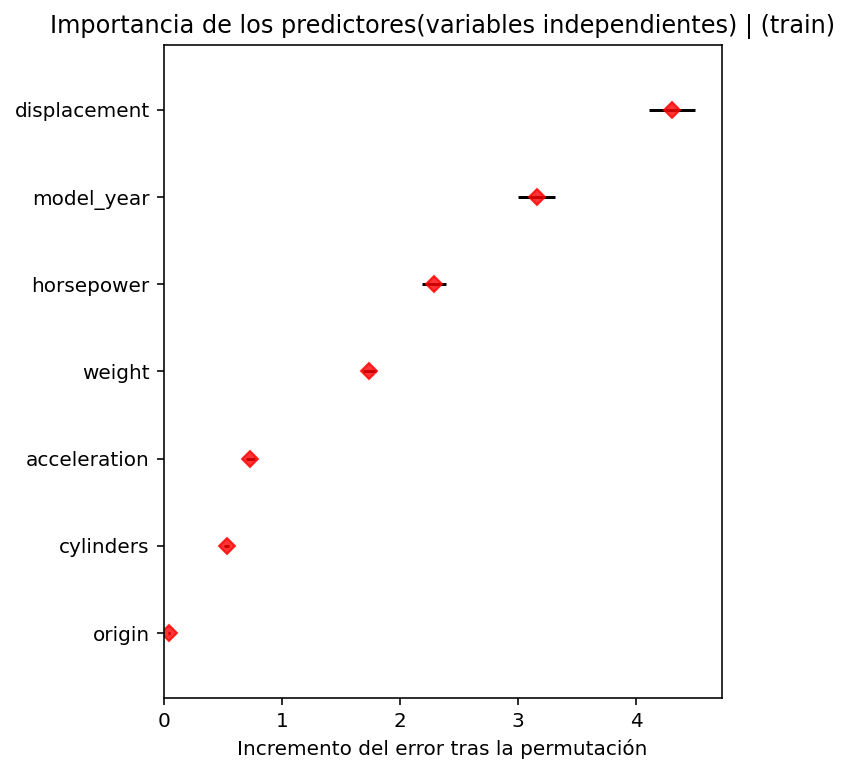

In [ ]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores(variables independientes) | (train)')
ax.set_xlabel('Incremento del error tras la permutación'); ## Las mejores características(variables independientes) tbm hacen subir el error

## Random Forests | Hiperparametros | Validacion Cruzada

In [ ]:
##########################################################################################################################
##########################################################################################################################
########################## Estimando cantidad de arboles(n_estimators) ###################################################
##########################################################################################################################
##########################################################################################################################

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


Valor óptimo de n_estimators: 121


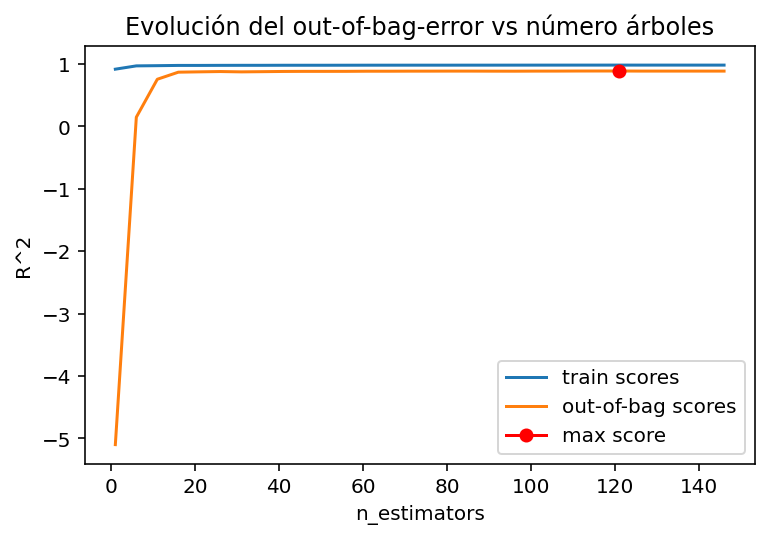

In [ ]:
# Validación empleando el Out-of-Bag error r2 de error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(x_train, y_train)
    train_scores.append(modelo.score(x_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 41


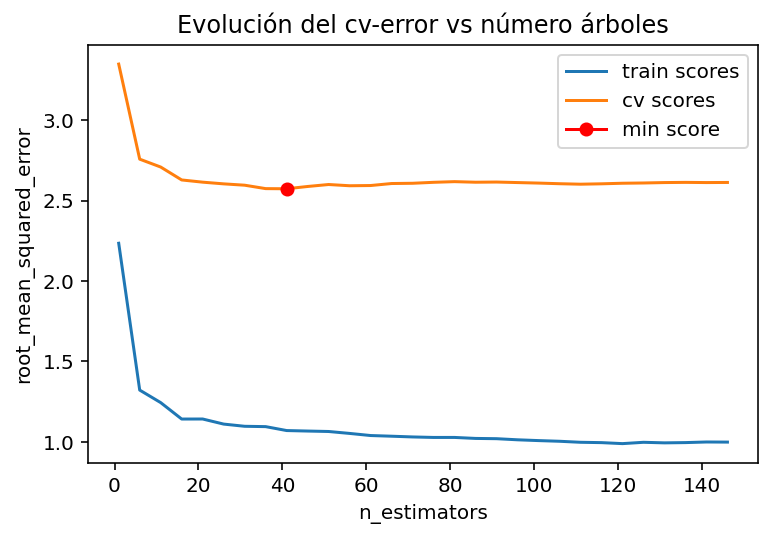

In [ ]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(x_train, y_train)
    predicciones = modelo.predict(X = x_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = x_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

In [ ]:
print("Entre 41 a 121 seria el valor de numero de arboles(n_estimators) ")

In [ ]:
##########################################################################################################################################################
##########################################################################################################################################################
###################################### VALIDACION CRUZADA para encontrar los valores de los hiperparametros ##############################################
##########################################################################################################################################################
##########################################################################################################################################################
################################################ n_estimators, max_features, max_depth ###################################################################



In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [200]   #Para la data tenemos sugerencias entre 41 a 1212
              ,'max_features': [3, 5, 7]  #Tenemos 7 variables independientes
              ,'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = x_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
0,None,3,200,-2.599627,0.415441,-0.980535,0.045104
9,20,3,200,-2.599627,0.415441,-0.980535,0.045104
6,10,3,200,-2.609814,0.419846,-1.012144,0.049302
7,10,5,200,-2.616788,0.445792,-0.997252,0.046183


In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': None, 'max_features': 3, 'n_estimators': 200} : -2.5996270324102055 neg_root_mean_squared_error


In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
y_test_pred_mf = modelo_final.predict(X = x_test)
rmse_mf = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_test_pred_mf,
        squared = False
       )

print(f"GridSearchCV :: El error (rmse) de test es: {rmse_mf}")    #Las predicciones del modelo  se alejan en promedio 3.12 mpg (antes de la validacion cruzada era 3.22 mpg )
print('GridSearchCV :: R^2', r2_score(y_true = y_test, y_pred = y_test_pred_mf))
print('GridSearchCV :: Error absoluto medio de test es: ', mean_absolute_error(y_test_pred_mf, y_test))  ##Las predicciones del modelo final se alejan en promedio 2.14 mpg del valor real



GridSearchCV :: El error (rmse) de test es: 3.1246579078062835
GridSearchCV :: R^2 0.8331230454850852
GridSearchCV :: Error absoluto medio de test es:  2.0488571428571443


In [ ]:
#Ejemplos de Obtención de estimaciones
x_ejem_1 = np.array([[4, 119, 80, 3000, 17, 73, 2]] )
print('Ejemplo Estimacion (1):', modelo_final.predict( x_ejem_1 ))

x_ejem_2 = np.array([[6, 116, 83, 2700, 21, 70, 3]] )
print('Ejemplo Estimacion (2):', modelo_final.predict( x_ejem_2 ))

x_ejem = np.concatenate( (x_ejem_1, x_ejem_2 ) )


Ejemplo Estimacion (1): [22.4005]
Ejemplo Estimacion (2): [23.435]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


## Regresión Lineal

# SECCION 2 EJEMPLO

In [ ]:
#import pandas as pd
df_crimen = pd.read_csv('csv_crime_data.csv', delimiter=',' )

#df_crimen.head()
df_crimen.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


### Regresión lineal con de scikit-learn
En `scikit-learn` los modelos de regresión lineal se implementa con la clase `LinearRegression`. En el siguiente ejemplo se muestra los pasos necesarios para conseguir una regresión lineal.

# Sección 1er Ejemplo

In [ ]:
#####################################################
########## ARCHIVO AUTO.csv #########################
#####################################################



In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
###from numpy import np

#### Conjunto de datos
#print(len(df_auto.columns))
print("====================x_train===============================")
x_train = df_auto.iloc[:, :(len(df_auto.columns)-1)]
print(x_train.shape)
x_train.info(verbose = False)
#print(x_train)

print("====================y_train===============================")
y_train = df_auto.iloc[:,-1]
print(y_train.shape)
y_train.head()
print(y_train)

x_train_ori = x_train
x_train = x_train.values

y_train_ori = y_train
y_train = y_train.values


====================x_train===============================
(392, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Columns: 7 entries, cylinders to origin
dtypes: float64(4), int64(3)
memory usage: 21.6 KB
====================y_train===============================
(392,)
0      18.0
1      15.0
2      18.0
3      16.0
4      17.0
       ... 
387    27.0
388    44.0
389    32.0
390    28.0
391    31.0
Name: mpg, Length: 392, dtype: float64


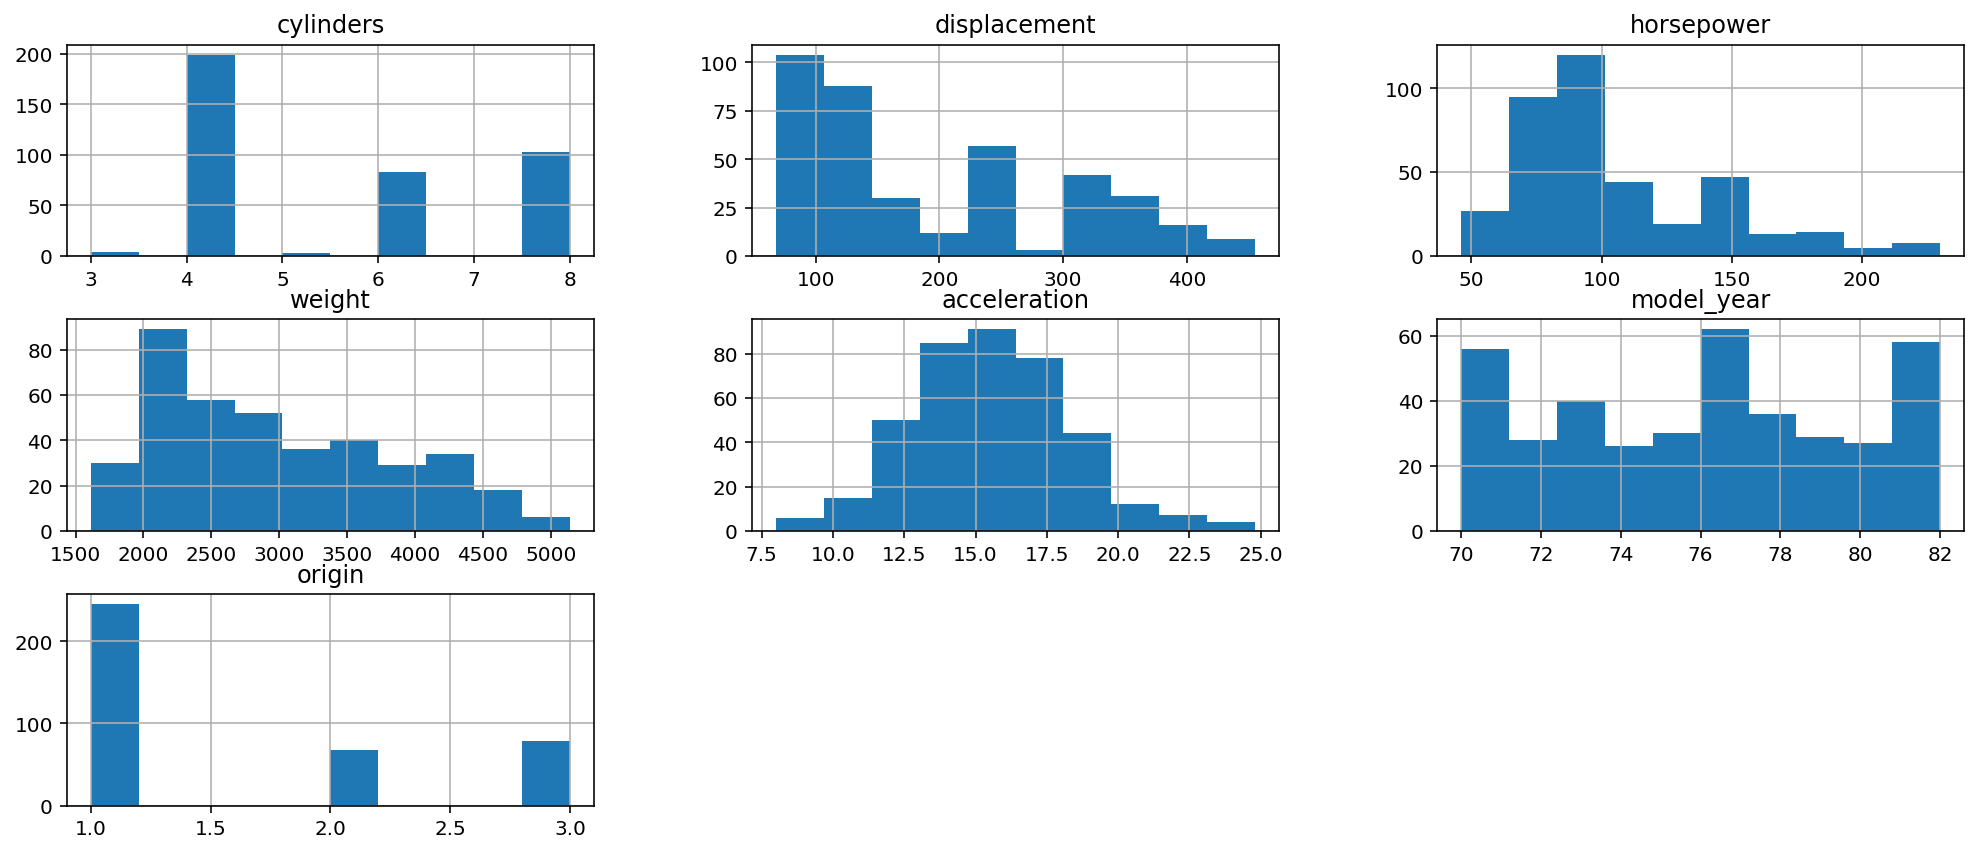

In [ ]:
###################################################
###### Vision General de las Variables ############
###################################################

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [17, 7]

#Nos muestra entre qué valores se concentran la mayoría de registros
x_train_ori.hist()
plt.show()

In [ ]:
#######################################################
############# Funciones Varias ########################

def imprimir_datos_modelo(modelo, x_ori, x, y):
  # Obtención de los parametros de ajuste
  print('w_0', modelo.intercept_)

  ##print(modelo.coef_)
  print(modelo.coef_.tolist())
  ##print('w_1:%s, w_2:%s, w_3:%s, w_4:%s, w_5:%s, w_6:%s, w_7:%s' %(modelo.coef_[0], modelo.coef_[1], modelo.coef_[2], modelo.coef_[3], modelo.coef_[4], modelo.coef_[5], modelo.coef_[6] ))

  # Predicción del modelo
  y_pred = modelo.predict(x);


  print('R^2 (A)', modelo.score(x, y))
  print('R^2 (B)', r2_score(y, y_pred))
  i_mse_1 = mean_squared_error(y_pred, y)
  i_mse_2 = mean_squared_error(y_true = y, y_pred = y_pred)
  print('Error cuadrático medio: %.4f' %(i_mse_1))
  #print('Error cuadrático medio (2): %.4f' %(i_mse_2))
  print('Error absoluto medio', mean_absolute_error(y_pred, y)) ##En cada prediccion del consumo en millas por galon(mpg) hay un error de 2.499 y es menor que la desviacion_estandar
  print('Mediana del error absoluto', median_absolute_error(y_pred, y))
  print('Error Cuadrático Medio = ' + str(np.sqrt(i_mse_1)))
  print("\n\n")
  #print('Error Cuadrático Medio (MSE 2) = ' + str(np.sqrt(i_mse_2)))

  #print(pd.DataFrame(modelo.coef_, x_ori.columns, columns=['Coefficient']))  ##Por cada 1mpg sube 0.08 la aceleracion
  

def imprimir_datos_modelo_CV(modelo, x_ori, x, y):
  # Obtención de los parametros de ajuste
  #print('w_0', modelo.intercept_)

  ##print(modelo.coef_)
  #print(modelo.coef_.tolist())
  

  # Predicción del modelo
  y_pred = modelo.predict(x);


  print('R^2 (A)', modelo.score(x, y))
  print('R^2 (B)', r2_score(y, y_pred))
  i_mse_1 = mean_squared_error(y_pred, y)
  i_mse_2 = mean_squared_error(y_true = y, y_pred = y_pred)
  print('Error cuadrático medio: %.4f' %(i_mse_1))
  #print('Error cuadrático medio (2): %.4f' %(i_mse_2))
  print('Error absoluto medio', mean_absolute_error(y_pred, y)) ##En cada prediccion del consumo en millas por galon(mpg) hay un error de 2.499 y es menor que la desviacion_estandar
  print('Mediana del error absoluto', median_absolute_error(y_pred, y))
  print('Error Cuadrático Medio = ' + str(np.sqrt(i_mse_1)))
  print("\n\n")
  #print('Error Cuadrático Medio (MSE 2) = ' + str(np.sqrt(i_mse_2)))

  #print(pd.DataFrame(modelo.coef_, x_ori.columns, columns=['Coefficient']))  ##Por cada 1mpg sube 0.08 la aceleracion
  





In [ ]:
#####################################################################################################
################################## Creación del modelo con todas las variables ######################
#####################################################################################################

model_rl = LinearRegression() 
model_rl.fit(x_train, y_train)  #x_train tiene mas de 1 variable y por eso es de multiple variables

imprimir_datos_modelo(model_rl, x_train_ori, x_train, y_train)


w_0 -17.218434622017536
[-0.4933763188584681, 0.019895643742017112, -0.016951144227501214, -0.006474043397440444, 0.0805758383248626, 0.7507726779503117, 1.42614049542315]
R^2 (A) 0.8214780764810599
R^2 (B) 0.8214780764810599
Error cuadrático medio: 10.8475
Error absoluto medio 2.499309832500872
Mediana del error absoluto 2.0220944142858706
Error Cuadrático Medio = 3.2935514183022025
              Coefficient
cylinders       -0.493376
displacement     0.019896
horsepower      -0.016951
weight          -0.006474
acceleration     0.080576
model_year       0.750773
origin           1.426140


In [ ]:
#Ejemplos de Obtención de estimaciones
x_ejem_1 = np.array([[4, 119, 80, 3000, 17, 73, 2]] )
print('Ejemplo Estimacion (1):', model_rl.predict( x_ejem_1 ))

x_ejem_2 = np.array([[6, 116, 83, 2700, 21, 70, 3]] )
print('Ejemplo Estimacion (2):', model_rl.predict( x_ejem_2 ))
###print(type(x_ejem_1)) #numpy.ndarray
###print(type(x_train))  #numpy.ndarray
###print(x_train) 

x_ejem = np.concatenate( (x_ejem_1, x_ejem_2 ) )
###print(type(x_ejem))
###print(x_ejem)

Ejemplo Estimacion (1): [21.42589571]
Ejemplo Estimacion (2): [21.76694154]


((2)) Entrenaremos el modelo con 2 variables independientes: displacement, housepower "

In [ ]:
#####################################################################################################
################################## Creación del modelo con 2 variables Independientes ###############
#####################################################################################################
####displacement, horsepower


#print(type(x_train_ori))
x_train_ori.describe()

x_train_di_ho = x_train_ori[['displacement','horsepower']]
#x_train_di_ho.describe()
model_rl_di_ho = LinearRegression()
model_rl_di_ho.fit(x_train_di_ho, y_train)

imprimir_datos_modelo(model_rl_di_ho, x_train_di_ho, x_train_di_ho, y_train)


w_0 37.469487668030396
[-0.04081837430358191, -0.05827532890650249]
R^2 (A) 0.6643293016845742
R^2 (B) 0.6643293016845742
Error cuadrático medio: 20.3963
Error absoluto medio 3.4703421871100373
Mediana del error absoluto 2.998689103815556
Error Cuadrático Medio = 4.516223072932701
              Coefficient
displacement    -0.040818
horsepower      -0.058275


Text(0.5, 0.92, 'Regresión Lineal con Múltiples Variables')

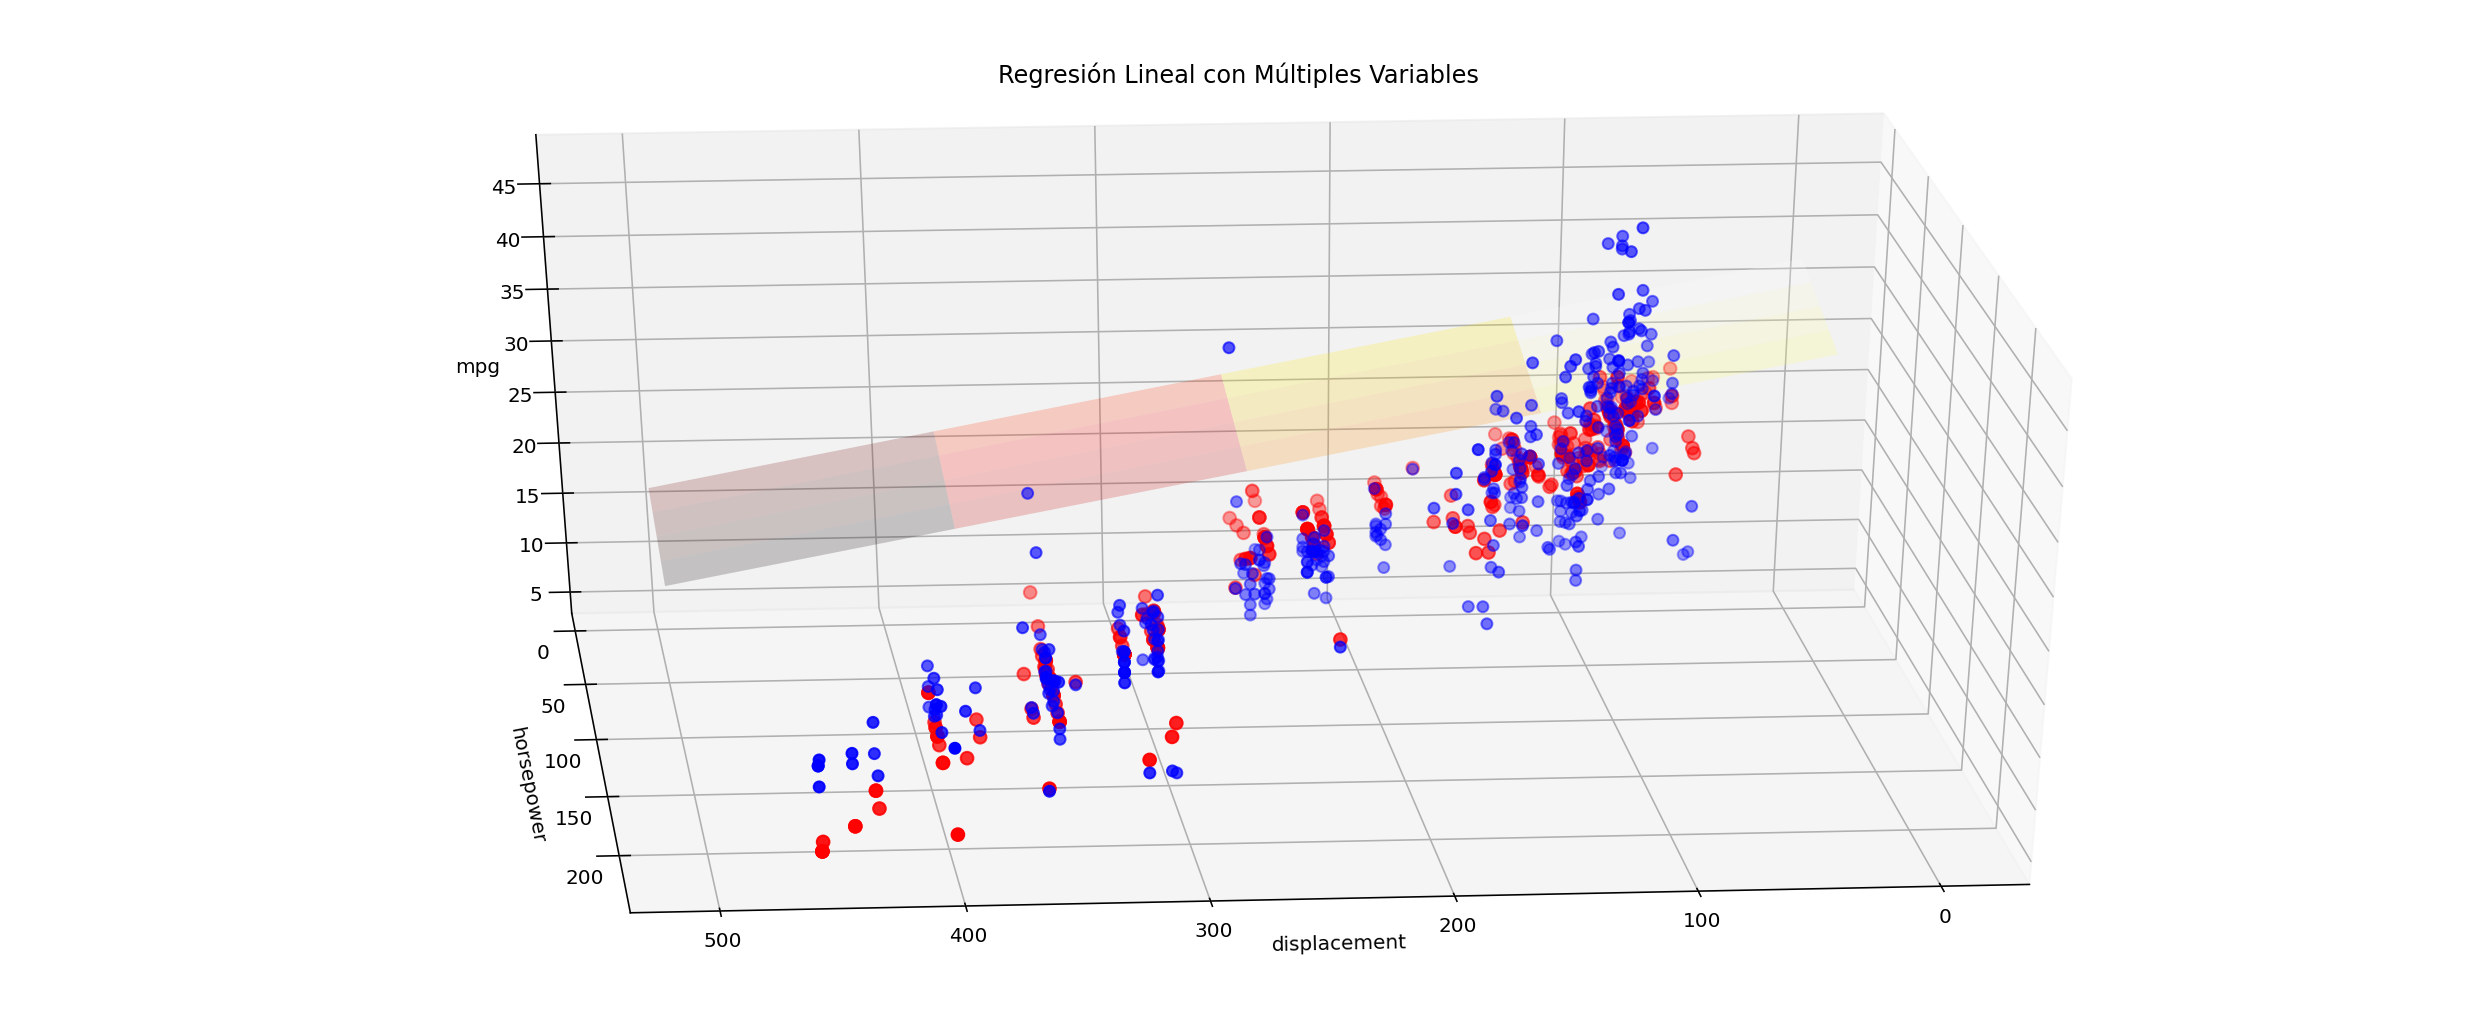

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

#plt.rcParams['figure.figsize'] = [17, 7]

fig = plt.figure()
ax = Axes3D(fig)

# Creamos una malla, sobre la cual graficaremos el plano
xx, yy = np.meshgrid(np.linspace(0, 500, num=5), np.linspace(0, 60, num=5))

# calculamos los valores del plano para los puntos x e y
nuevoX = (model_rl_di_ho.coef_[0] * xx)
nuevoY = (model_rl_di_ho.coef_[1] * yy) 

# calculamos los correspondientes valores para z. Debemos sumar el punto de intercepción
z = (nuevoX + nuevoY + model_rl_di_ho.intercept_)

# Graficamos el plano
ax.plot_surface(xx, yy, z, alpha=0.2, cmap='hot')

# Graficamos en azul los puntos en 3D que son reales
ax.scatter(x_train_di_ho['displacement'], x_train_di_ho['horsepower'], y_train, c='blue',s=30)

# Graficamos en rojo, los puntos que son predecidos por las variables independientes
ax.scatter(x_train_di_ho['displacement'], x_train_di_ho['horsepower'], model_rl_di_ho.predict(x_train_di_ho), c='red',s=40)

# con esto situamos la "camara" con la que visualizamos
ax.view_init(elev=30., azim=85)
        
ax.set_xlabel('displacement')
ax.set_ylabel('horsepower')
ax.set_zlabel('mpg')
ax.set_title('Regresión Lineal con Múltiples Variables')



In [ ]:
#####################################################################################################
################################## Creación del modelo con 3 variables Independientes ###############
#####################################################################################################
####weight, acceleration, horsepower


#print(type(x_train_ori))
x_train_ori.describe()

x_train_we_ac_ho = x_train_ori[['weight','acceleration', 'horsepower']]
#x_train_we_ac_ho.describe()
model_rl_we_ac_ho = LinearRegression()
model_rl_we_ac_ho.fit(x_train_we_ac_ho, y_train)

imprimir_datos_modelo(model_rl_we_ac_ho, x_train_we_ac_ho, x_train_we_ac_ho, y_train)

w_0 45.678292876956434
[-0.005789402592259163, -0.002065657852236849, -0.04749561533211885]
R^2 (A) 0.7063754859981903
R^2 (B) 0.7063754859981903
Error cuadrático medio: 17.8414
Error absoluto medio 3.235720179777735
Mediana del error absoluto 2.5962018848364075
Error Cuadrático Medio = 4.223911640238705
              Coefficient
weight          -0.005789
acceleration    -0.002066
horsepower      -0.047496


In [ ]:
#Ejemplos de Obtención de estimaciones
x_ejem_1 = np.array([[80, 3000, 17]] )
print('Ejemplo Estimacion (1):', model_rl_we_ac_ho.predict( x_ejem_1 ))

x_ejem_2 = np.array([[83, 2700, 21]] )
print('Ejemplo Estimacion (2):', model_rl_we_ac_ho.predict( x_ejem_2 ))
###print(type(x_ejem_1)) #numpy.ndarray
###print(type(x_train))  #numpy.ndarray
###print(x_train) 

x_ejem = np.concatenate( (x_ejem_1, x_ejem_2 ) )
###print(type(x_ejem))
###print(x_ejem)

Ejemplo Estimacion (1): [38.21074165]
Ejemplo Estimacion (2): [38.62308834]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
###################################################
########### Division de la data ###################
###################################################
from sklearn.model_selection import train_test_split

df_train_data, df_rest_data = train_test_split(df_auto, train_size=0.8, shuffle=False)

print("Dataframe: %s :: DataTrain: %s :: DataTest: %s" %(str(df_auto.shape), str(df_train_data.shape), str(df_rest_data.shape) ))

Dataframe: (392, 8) :: DataTrain: (313, 8) :: DataTest: (79, 8)


In [ ]:
print("====================x_train===============================")
x_80_train = df_train_data.iloc[:, :(len(df_train_data.columns)-1)]
print(x_80_train.shape)
x_80_train.info(verbose = False)
#print(x_80_train)

print("====================y_train===============================")
y_80_train = df_train_data.iloc[:,-1]
print(y_80_train.shape)
y_80_train.head()
print(y_80_train)

x_80_train_ori = x_80_train
x_80_train = x_80_train.values

y_80_train_ori = y_80_train
y_80_train = y_80_train.values

====================x_train===============================
(313, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 312
Columns: 7 entries, cylinders to origin
dtypes: float64(4), int64(3)
memory usage: 19.6 KB
====================y_train===============================
(313,)
0      18.0
1      15.0
2      18.0
3      16.0
4      17.0
       ... 
308    38.1
309    32.1
310    37.2
311    28.0
312    26.4
Name: mpg, Length: 313, dtype: float64


In [ ]:
model_80_rl = LinearRegression() 
model_80_rl.fit(x_80_train, y_80_train)  #x_train tiene mas de 1 variable y por eso es de multiple variables

imprimir_datos_modelo(model_80_rl, x_80_train_ori, x_80_train, y_80_train)

w_0 -1.5828103309052786
[-0.5194896120320369, 0.010213888287500143, -0.017766991643248083, -0.005572340609354387, -0.11267481204980456, 0.5820075106424497, 0.8480252377153485]
R^2 (A) 0.8211317823581514
R^2 (B) 0.8211317823581514
Error cuadrático medio: 8.0025
Error absoluto medio 2.14829768820156
Mediana del error absoluto 1.7611758661256722
Error Cuadrático Medio = 2.8288736547338877
              Coefficient
cylinders       -0.519490
displacement     0.010214
horsepower      -0.017767
weight          -0.005572
acceleration    -0.112675
model_year       0.582008
origin           0.848025


In [ ]:
print("====================x_test===============================")
x_20_test = df_rest_data.iloc[:, :(len(df_rest_data.columns)-1)]
print(x_20_test.shape)
x_20_test.info(verbose = False)
#print(x_20_test)

print("====================y_test===============================")
y_20_test = df_rest_data.iloc[:,-1]
print(y_20_test.shape)
y_20_test.head()
print(y_20_test)

x_20_test_ori = x_20_test
x_20_test = x_20_test.values

y_20_test_ori = y_20_test
y_20_test = y_20_test.values

====================x_test===============================
(79, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 313 to 391
Columns: 7 entries, cylinders to origin
dtypes: float64(4), int64(3)
memory usage: 4.9 KB
====================y_test===============================
(79,)
313    24.3
314    19.1
315    34.3
316    29.8
317    31.3
       ... 
387    27.0
388    44.0
389    32.0
390    28.0
391    31.0
Name: mpg, Length: 79, dtype: float64


In [ ]:
#imprimir_datos_modelo(model_80_rl, x_20_test_ori, x_20_test, y_20_test)

# Predicción del modelo
y_tmp_pred = model_80_rl.predict(x_20_test);
i_mse_2 = mean_squared_error(y_true = y_20_test, y_pred = y_tmp_pred)
print('Error cuadrático medio: %.4f' %(i_mse_2))
print('Error absoluto medio', mean_absolute_error(y_tmp_pred, y_20_test))



Error cuadrático medio: 27.4627
Error absoluto medio 3.9253077012143907


In [ ]:
#############################################################
################### Multicolinealidad #######################
#############################################################

print("Significa relación lineal perfecta o exacta entre algunas o todas las variables independientes(explicativas)")

Significa relación lineal perfecta o exacta entre algunas o todas las variables independientes(explicativas)


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
#Factor de inflación de la varianza( VIF )

vif_X = df_auto[['cylinders', 'displacement', 'horsepower',	'weight', 'acceleration', 'model_year', 'origin']] 
  
vif_data = pd.DataFrame() 
vif_data["feature"] = vif_X.columns 
  
vif_data["VIF"] = [variance_inflation_factor(vif_X.values, i) 
                          for i in range(len(vif_X.columns))] 

vif_data_sorted = vif_data.sort_values(by=['VIF'], ascending=False)

print(vif_data_sorted)

        feature         VIF
3        weight  139.454162
0     cylinders  117.708547
5    model_year  115.794614
1  displacement   96.909762
4  acceleration   69.699769
2    horsepower   67.072154
6        origin    8.469942


In [ ]:
x_train_ori.describe()

x_train_we_cy_my = x_train_ori[['weight','cylinders', 'model_year']]
#x_train_we_cy_my.describe()
model_rl_we_cy_my = LinearRegression()
model_rl_we_cy_my.fit(x_train_we_cy_my, y_train)

imprimir_datos_modelo(model_rl_we_cy_my, x_train_we_cy_my, x_train_we_cy_my, y_train)

w_0 -13.907605934976797
[-0.006365697499915227, -0.151729012593808, 0.7520200488347157]
R^2 (A) 0.8083884634554312
R^2 (B) 0.8083884634554312
Error cuadrático medio: 11.6428
Error absoluto medio 2.6050494318490864
Mediana del error absoluto 2.2031782291222193
Error Cuadrático Medio = 3.4121608516580593


In [ ]:
#Ejemplos de Obtención de estimaciones
x_ejem_1 = np.array([[3500, 6, 80]] )
print('Ejemplo Estimacion (1):', model_rl_we_cy_my.predict( x_ejem_1 ))

x_ejem_2 = np.array([[3200, 7, 79]] )
print('Ejemplo Estimacion (2):', model_rl_we_cy_my.predict( x_ejem_2 ))

x_ejem = np.concatenate( (x_ejem_1, x_ejem_2 ) )


Ejemplo Estimacion (1): [23.06368265]
Ejemplo Estimacion (2): [24.06964284]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
#########################################
######Correlacion de Pearson#############
#########################################

print("Este coeficiente sólo debe utilizarse para comparar variables cuantitativas(integer) y continuas(float)")

Este coeficiente sólo debe utilizarse para comparar variables cuantitativas(integer) y continuas(float)


Si este coeficiente es igual a 1 o -1 (o cercano a estos valores) significa que una variable es fruto de una transformación lineal de la otra. Teniendo una relación directa al tratarse de 1 (cuando una variable aumenta, la otra también), mientras que existirá una relación inversa al tratarse de -1 (cuando una variable aumenta la otra disminuye).

Mientras que, Si r = 0 (o cercano a este valor) no existe relación lineal, aunque puede existir algún otro tipo de relación no lineal

In [ ]:
plt.rcParams['figure.figsize'] = [17, 7]
df_auto.corr(method="pearson")

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
cylinders,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932,-0.777618
displacement,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535,-0.805127
horsepower,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171,-0.778427
weight,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005,-0.832244
acceleration,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746,0.423329
model_year,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528,0.580541
origin,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000,0.565209
mpg,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209,1.000000


In [ ]:
val_corr_pearson = df_auto.corr(method="pearson")

#plt.matshow(val_corr_pearson)
val_corr_pearson.style.background_gradient(cmap='coolwarm').set_precision(4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  after removing the cwd from sys.path.


,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
cylinders,1.0000,0.9508,0.8430,0.8975,-0.5047,-0.3456,-0.5689,-0.7776
displacement,0.9508,1.0000,0.8973,0.9330,-0.5438,-0.3699,-0.6145,-0.8051
horsepower,0.8430,0.8973,1.0000,0.8645,-0.6892,-0.4164,-0.4552,-0.7784
weight,0.8975,0.9330,0.8645,1.0000,-0.4168,-0.3091,-0.5850,-0.8322
acceleration,-0.5047,-0.5438,-0.6892,-0.4168,1.0000,0.2903,0.2127,0.4233
model_year,-0.3456,-0.3699,-0.4164,-0.3091,0.2903,1.0000,0.1815,0.5805
origin,-0.5689,-0.6145,-0.4552,-0.5850,0.2127,0.1815,1.0000,0.5652
mpg,-0.7776,-0.8051,-0.7784,-0.8322,0.4233,0.5805,0.5652,1.0000


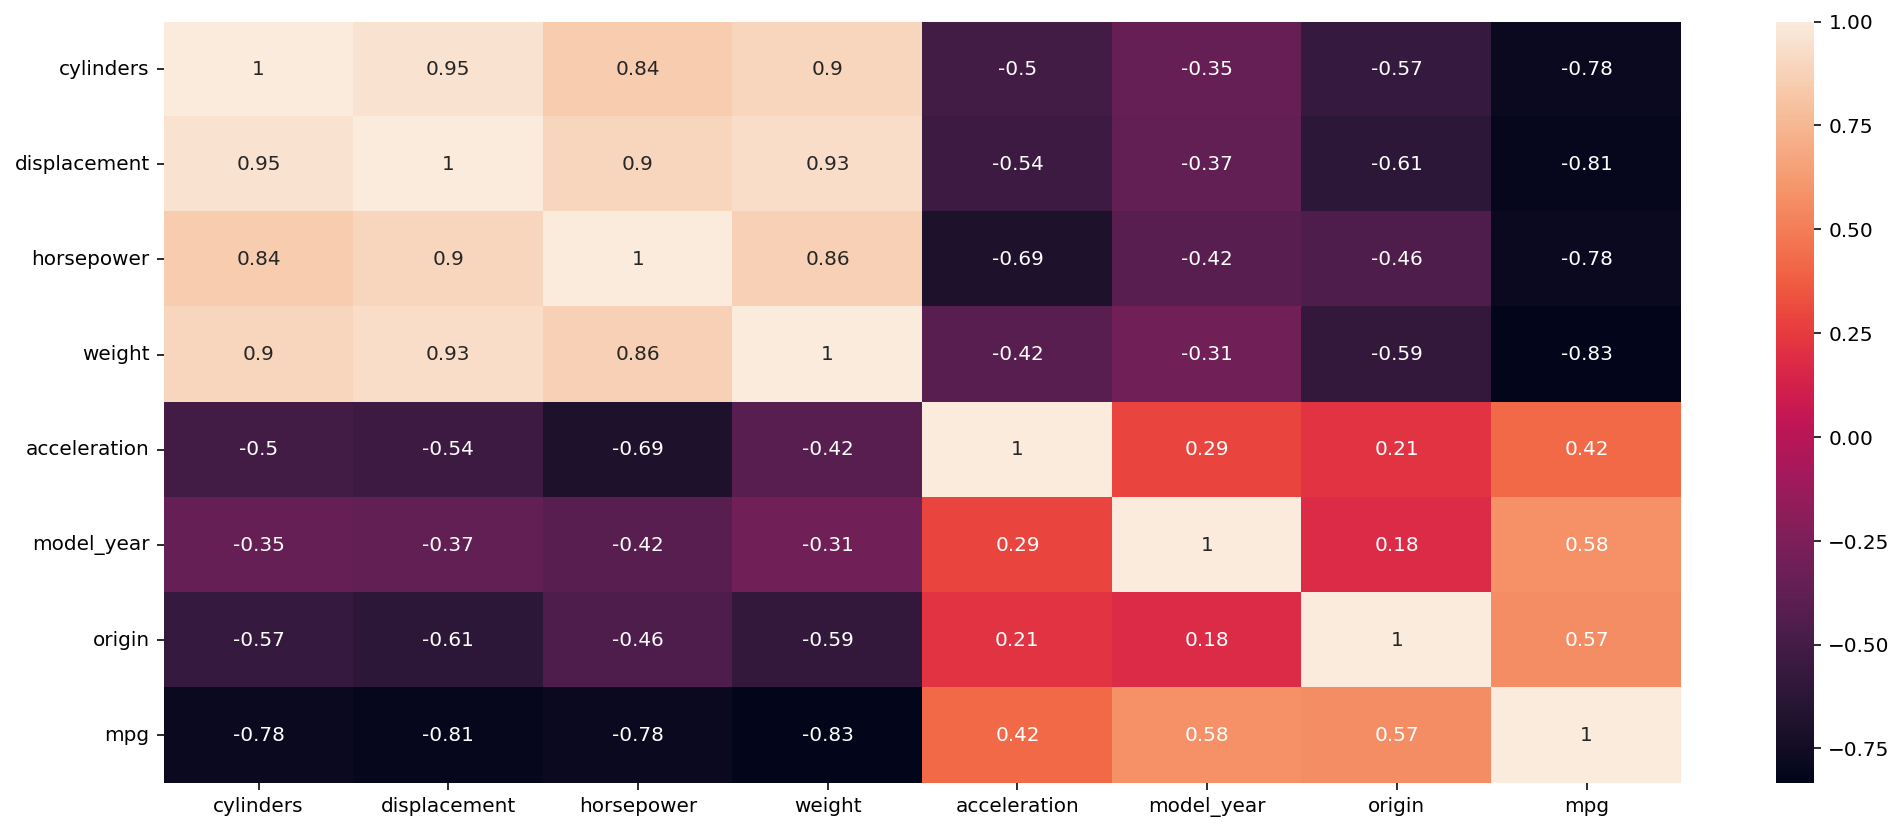

In [ ]:
import seaborn as sns

sns.heatmap(val_corr_pearson,  annot = True)

In [ ]:
x_train_ori.describe()

x_train_ac_my_or = x_train_ori[['acceleration','model_year', 'origin']]
#x_train_ac_my_or.describe()
model_rl_ac_my_or = LinearRegression()
model_rl_ac_my_or.fit(x_train_ac_my_or, y_train)

imprimir_datos_modelo(model_rl_ac_my_or, x_train_ac_my_or, x_train_ac_my_or, y_train)

w_0 -63.287296741182246
[0.5684913637368647, 0.9363388403235839, 4.285018149171664]
R^2 (A) 0.5915778650154857
R^2 (B) 0.5915778650154857
Error cuadrático medio: 24.8168
Error absoluto medio 4.0556812147080805
Mediana del error absoluto 3.534664832371675
Error Cuadrático Medio = 4.9816510678806285


In [ ]:
#Ejemplos de Obtención de estimaciones
x_ejem_1 = np.array([[17, 78, 1]] )
print('Ejemplo Estimacion (1):', model_rl_ac_my_or.predict( x_ejem_1 ))

x_ejem_2 = np.array([[18, 80, 1]] )
print('Ejemplo Estimacion (2):', model_rl_ac_my_or.predict( x_ejem_2 ))

x_ejem = np.concatenate( (x_ejem_1, x_ejem_2 ) )

Ejemplo Estimacion (1): [23.69650414]
Ejemplo Estimacion (2): [26.13767318]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


Text(0.5, 0, 'origin')

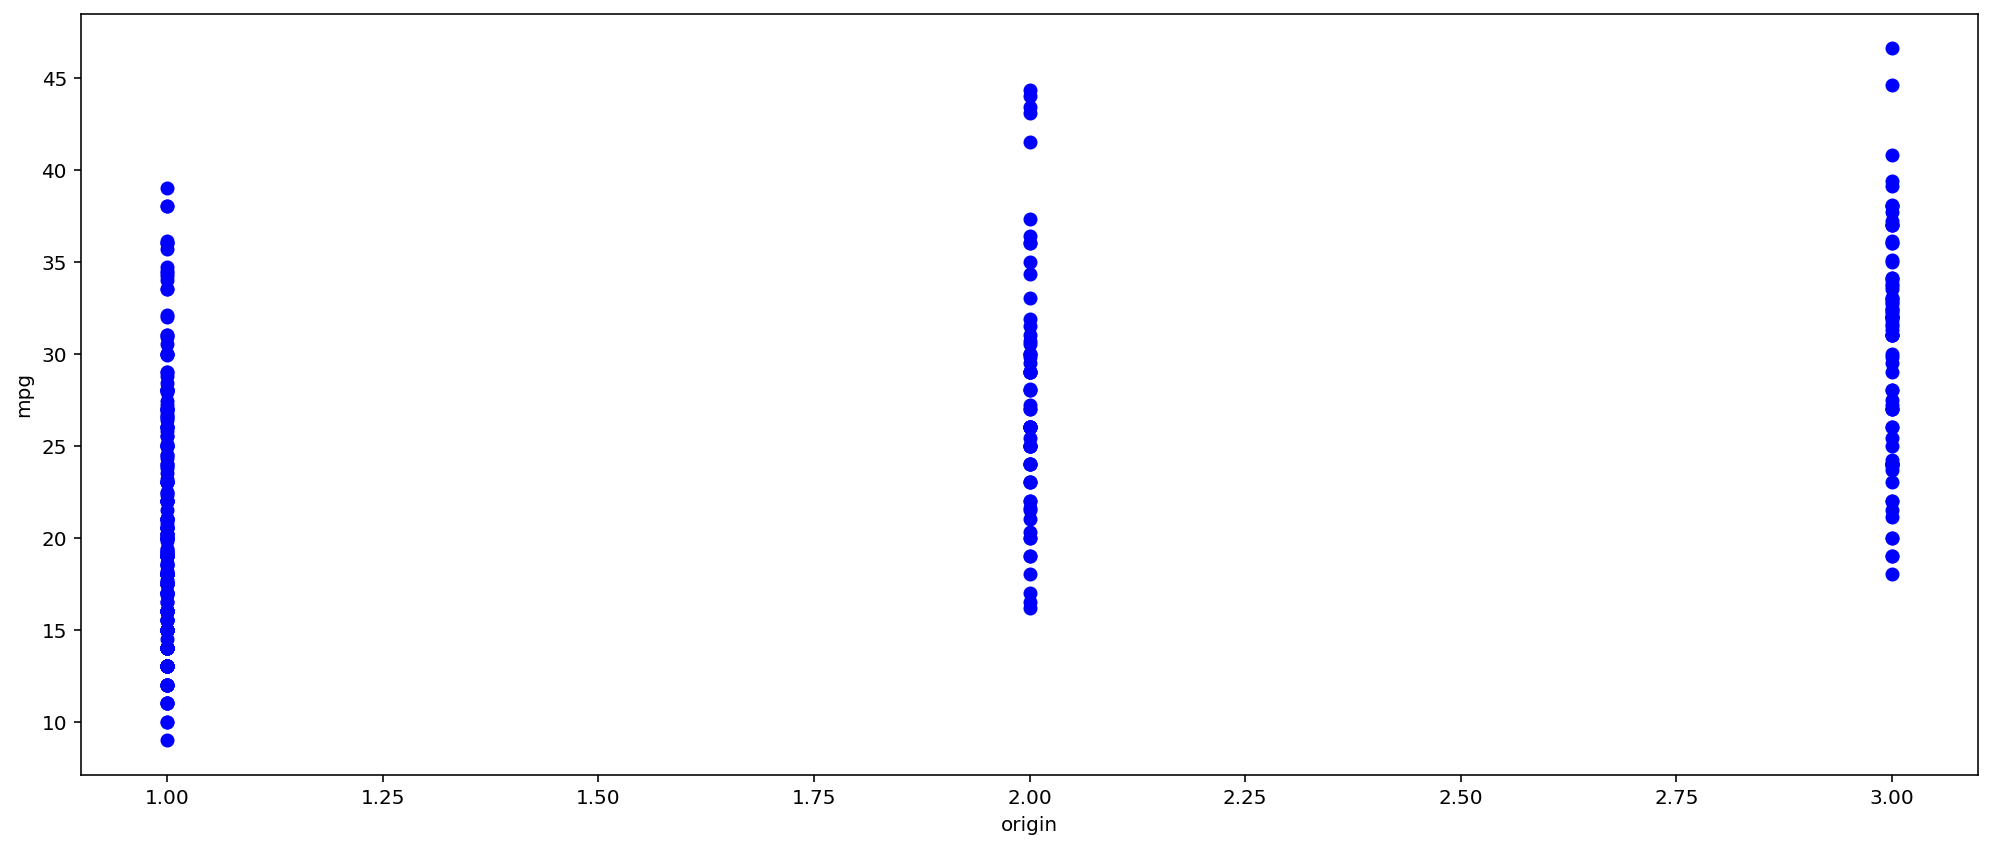

In [ ]:
plt.plot(df_auto['origin'], df_auto['mpg'], "bo")
plt.ylabel('mpg')
plt.xlabel('origin')

Text(0.5, 0, 'model_year')

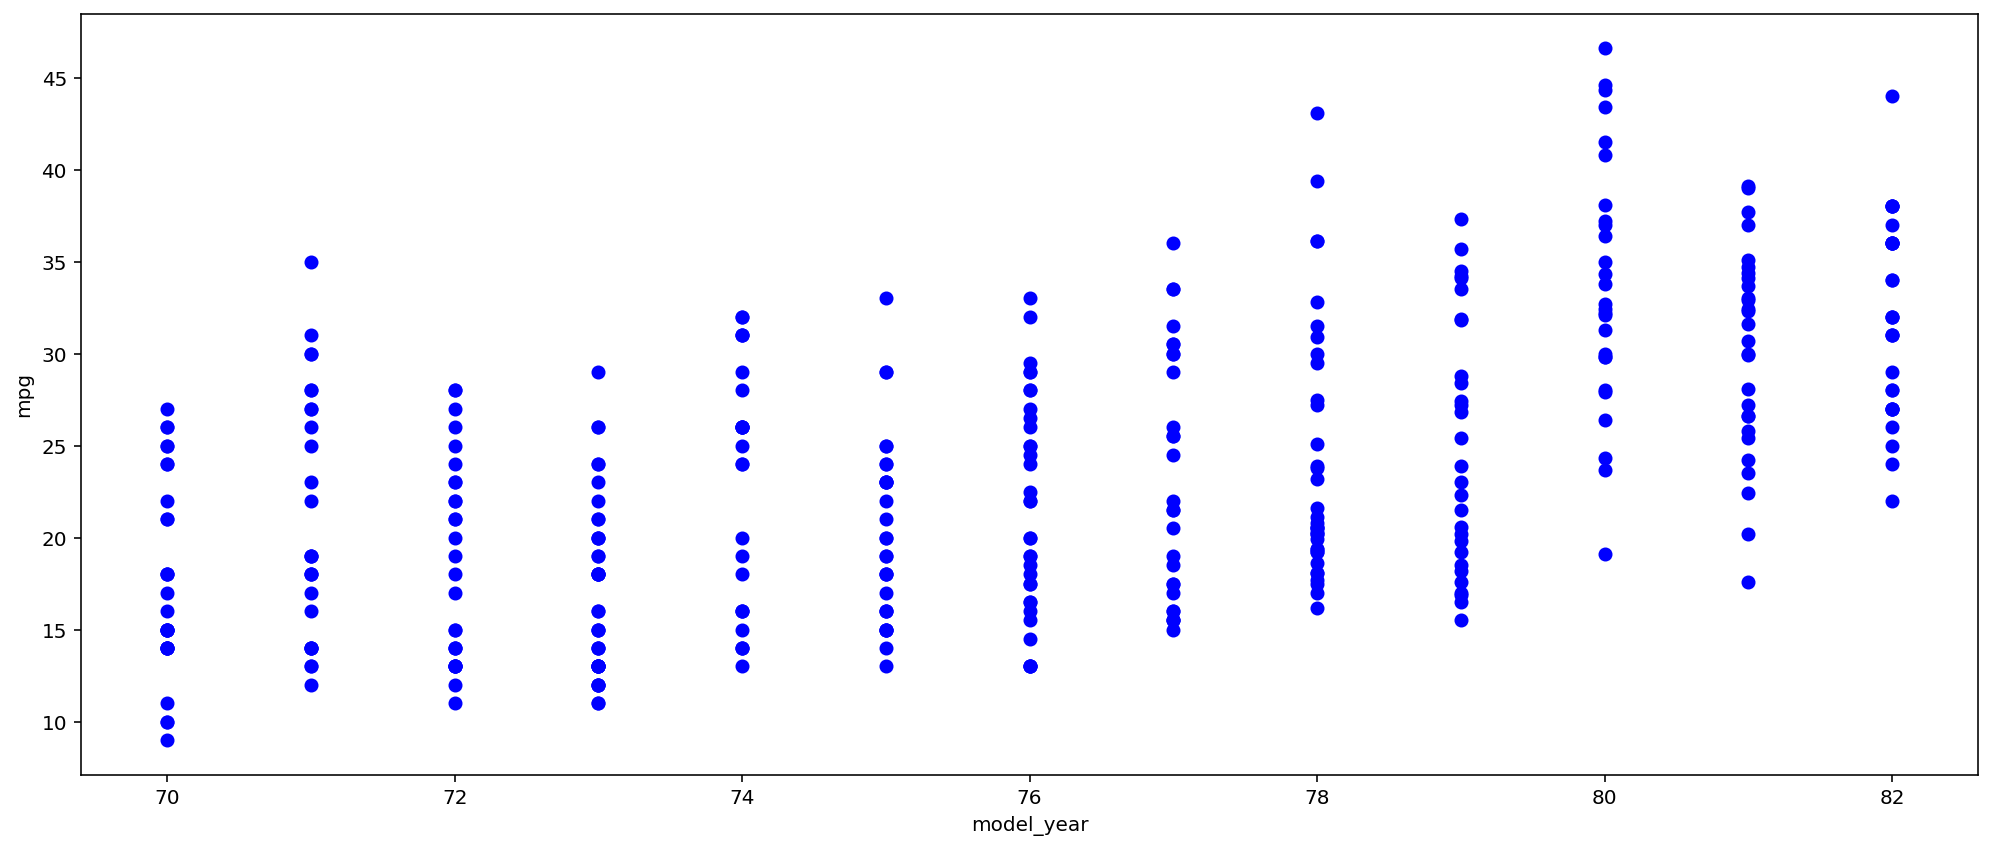

In [ ]:
plt.plot(df_auto['model_year'], df_auto['mpg'], "bo")
plt.ylabel('mpg')
plt.xlabel('model_year')

Text(0.5, 0, 'acceleration')

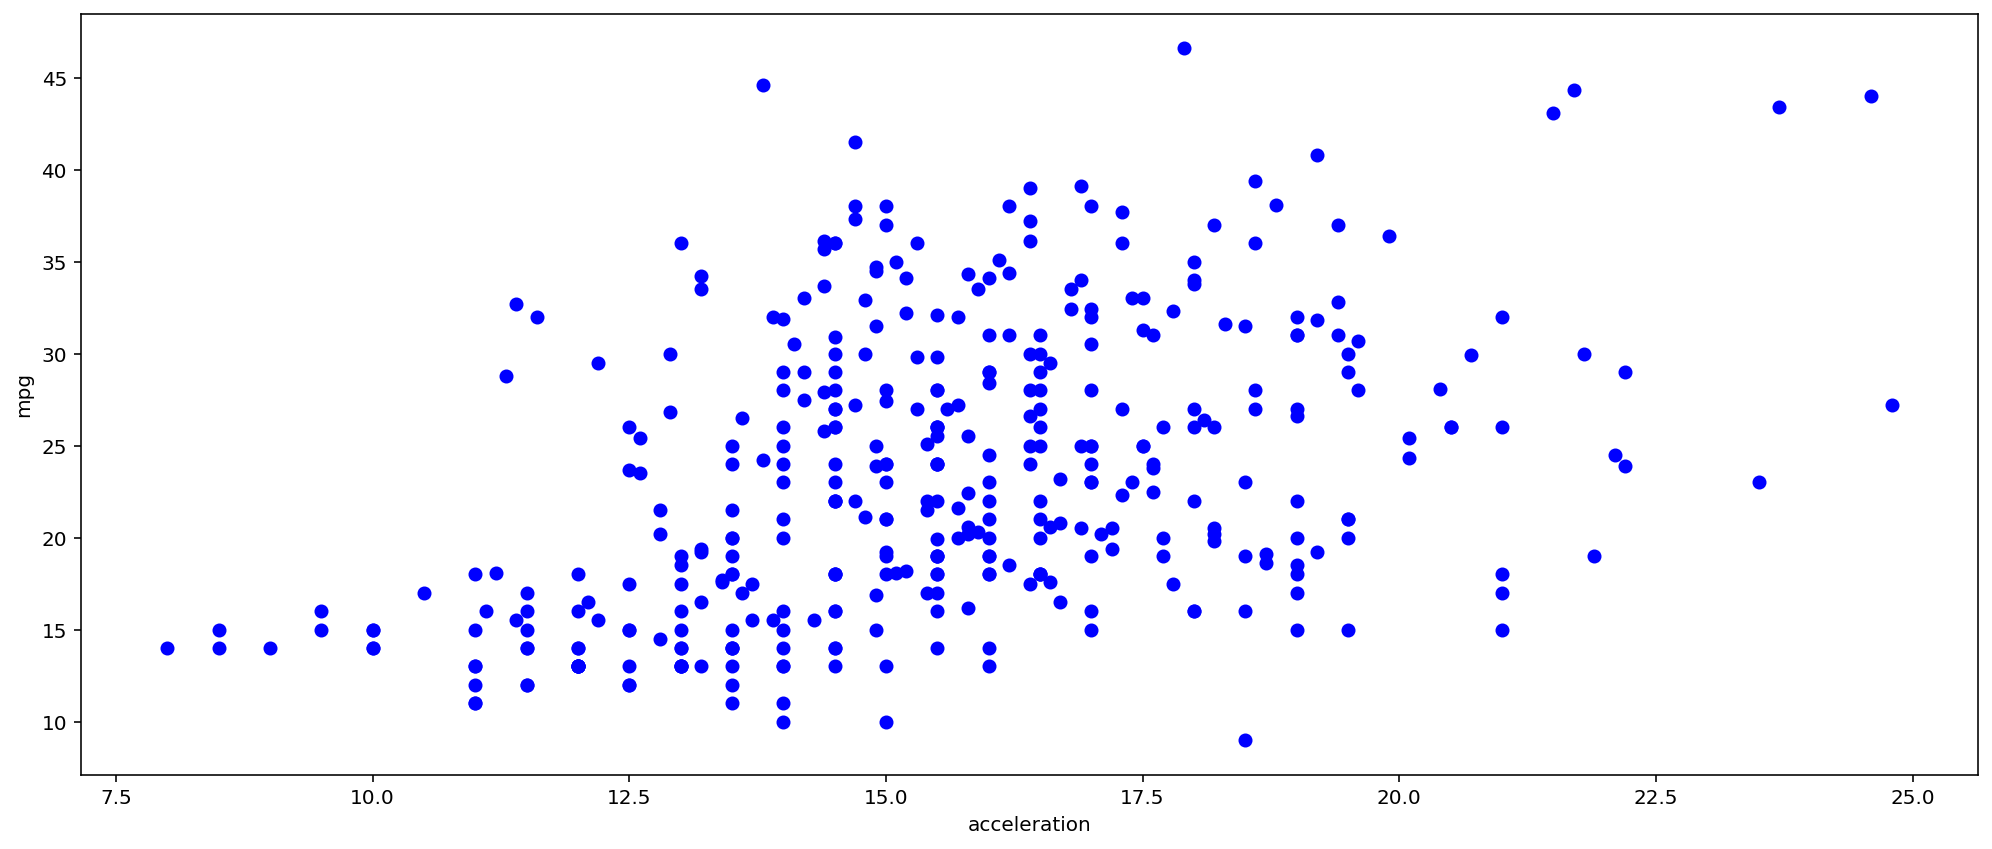

In [ ]:
plt.plot(df_auto['acceleration'], df_auto['mpg'], "bo")
plt.ylabel('mpg')
plt.xlabel('acceleration')


Text(0.5, 0, 'weight')

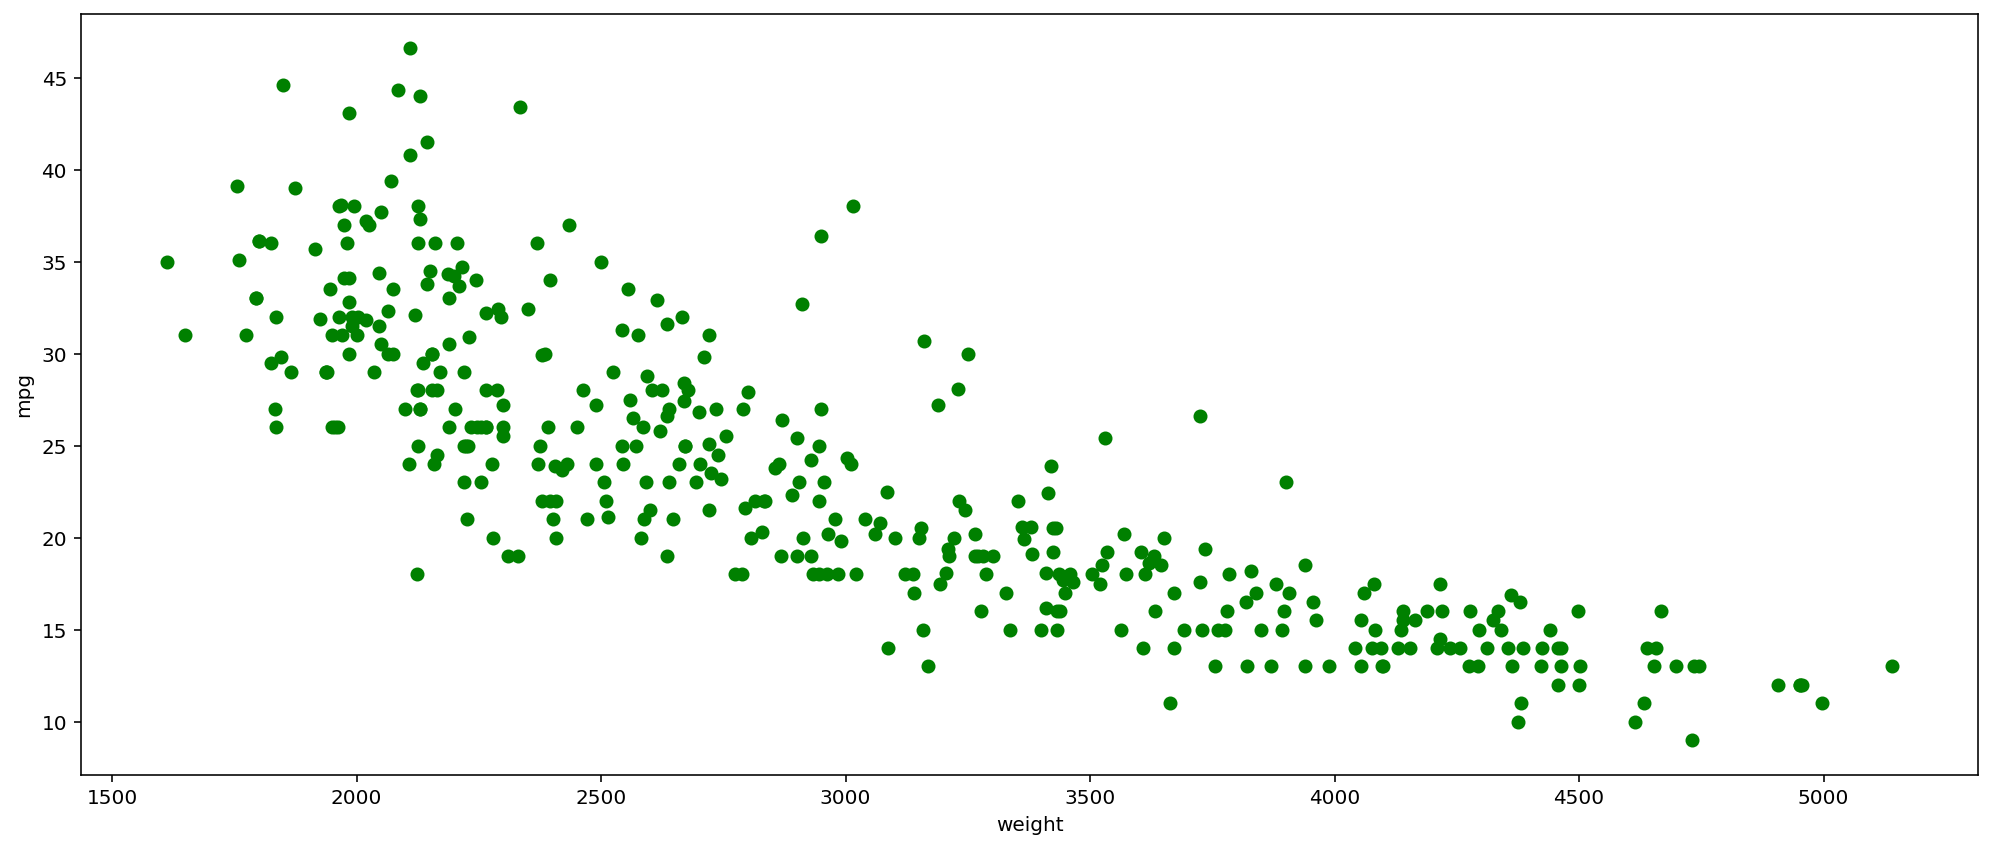

In [ ]:
plt.plot(df_auto['weight'], df_auto['mpg'], "bo", color='green')
plt.ylabel('mpg')
plt.xlabel('weight')


Text(0.5, 0, 'horsepower')

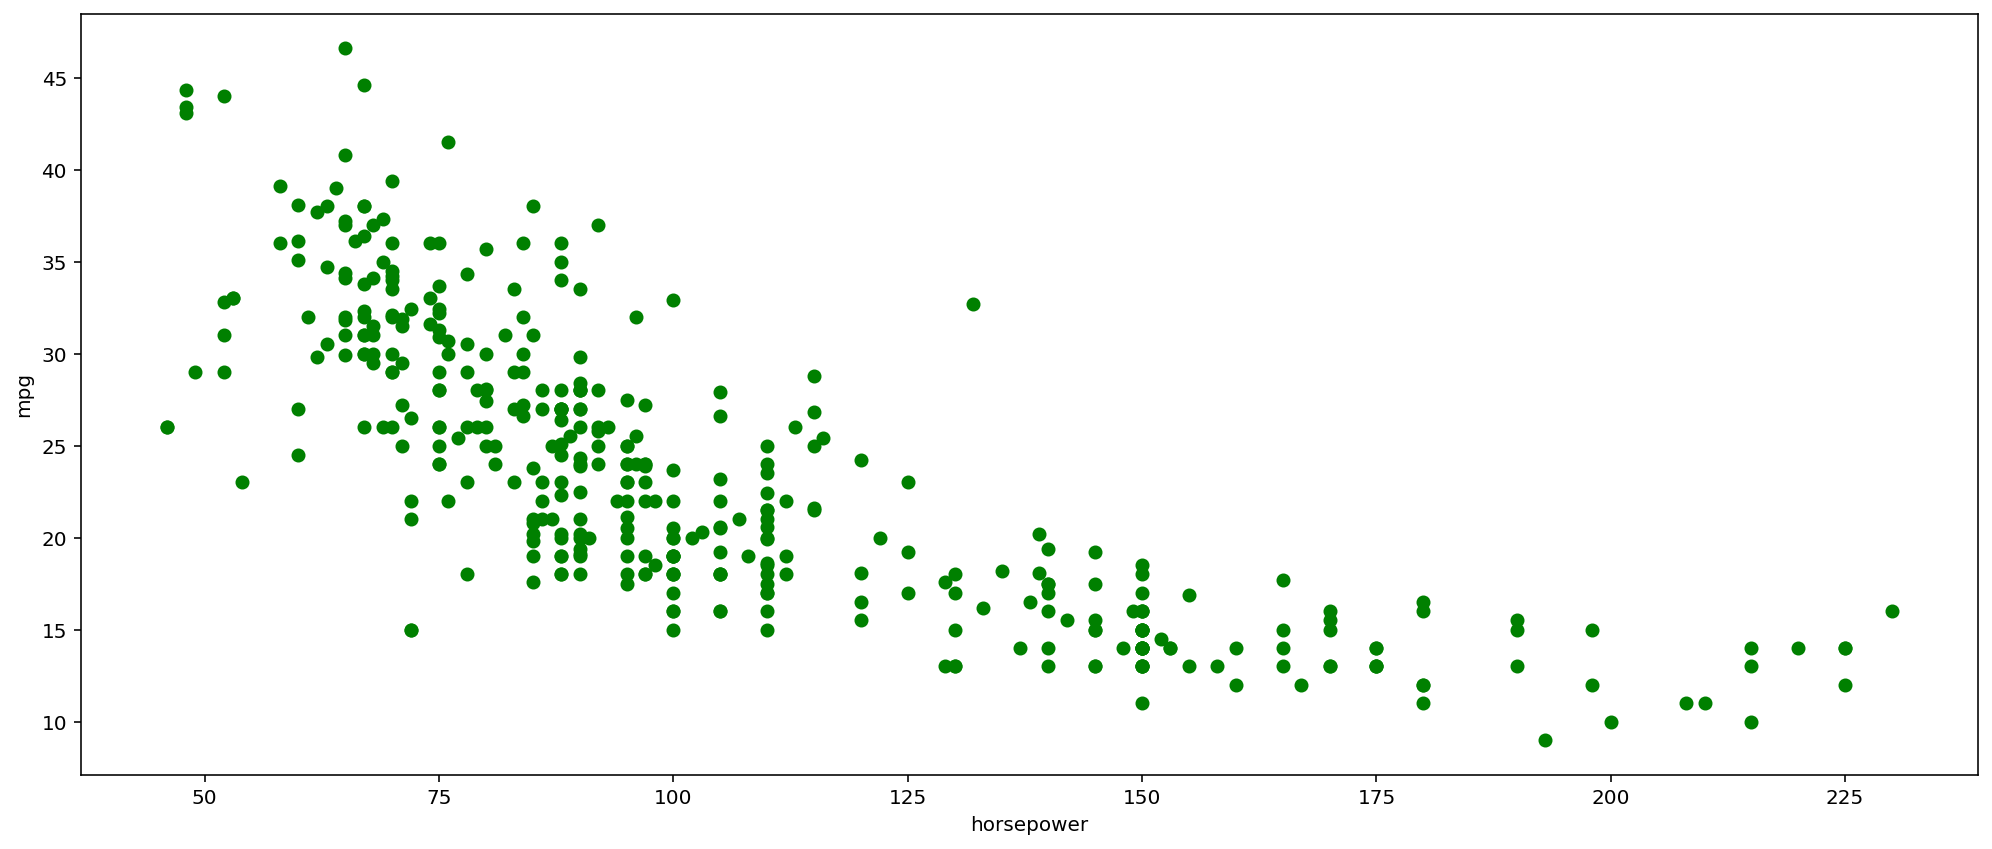

In [ ]:
plt.plot(df_auto['horsepower'], df_auto['mpg'], "bo", color='green')
plt.ylabel('mpg')
plt.xlabel('horsepower')

Text(0.5, 0, 'displacement')

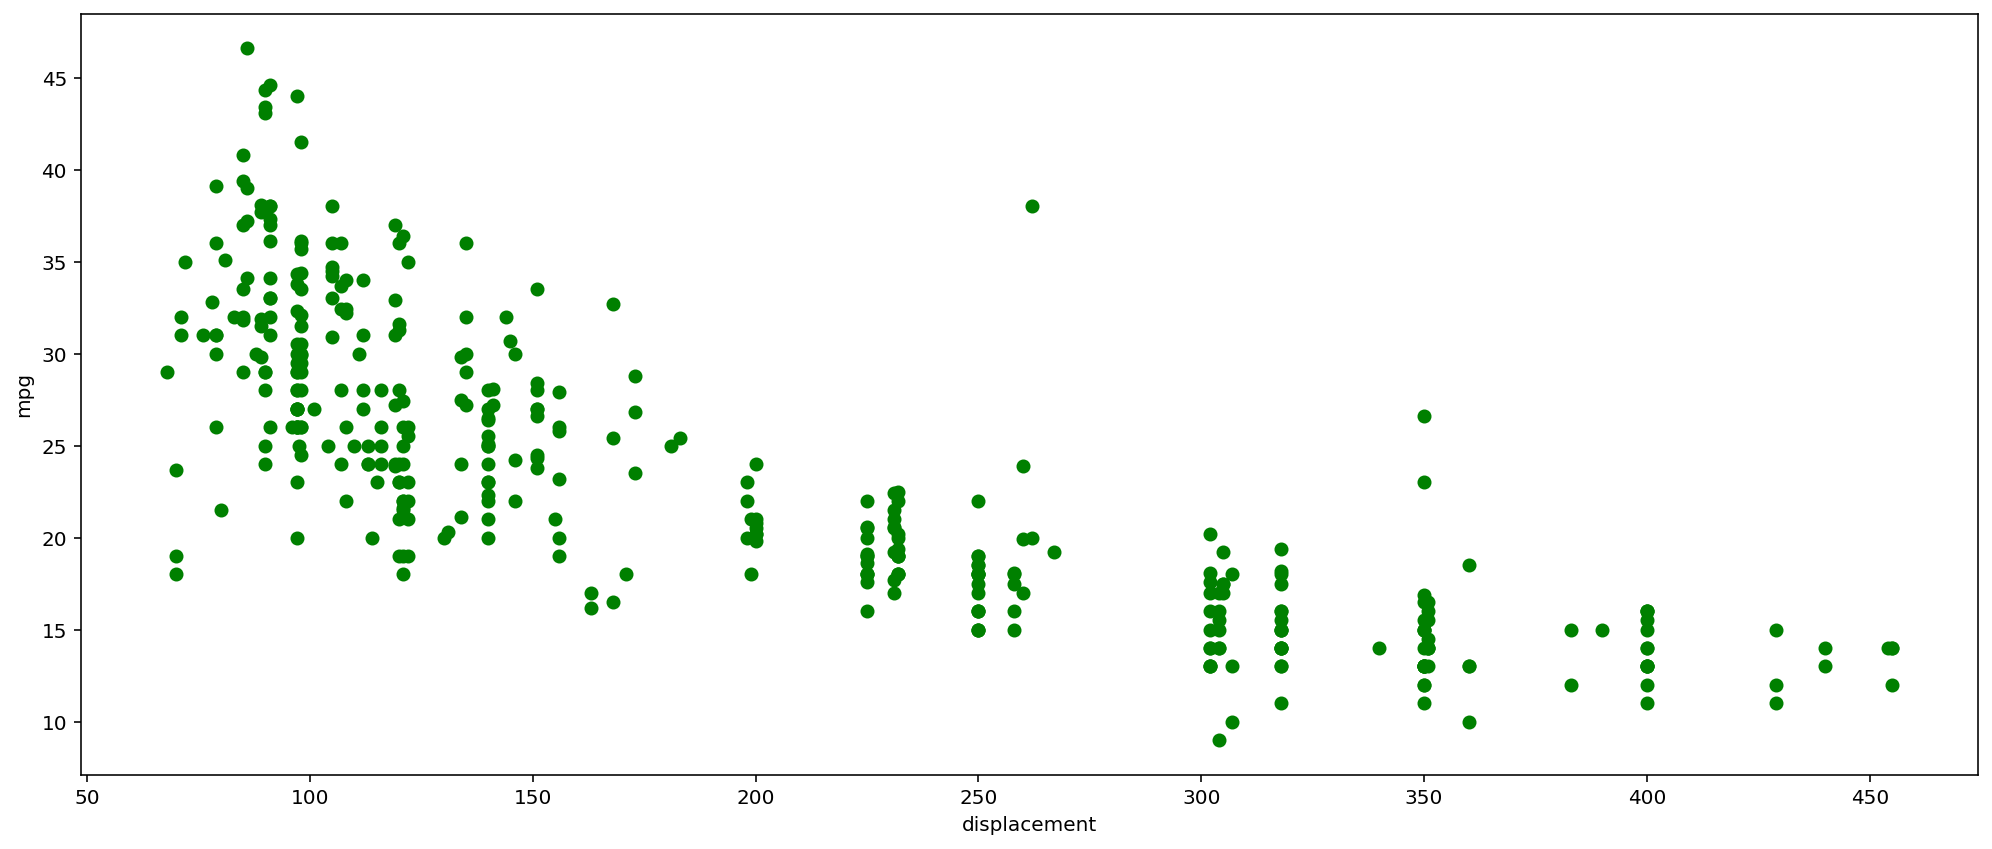

In [ ]:

plt.plot(df_auto['displacement'], df_auto['mpg'], "bo", color='green')
plt.ylabel('mpg')
plt.xlabel('displacement')


Text(0.5, 0, 'cylinders')

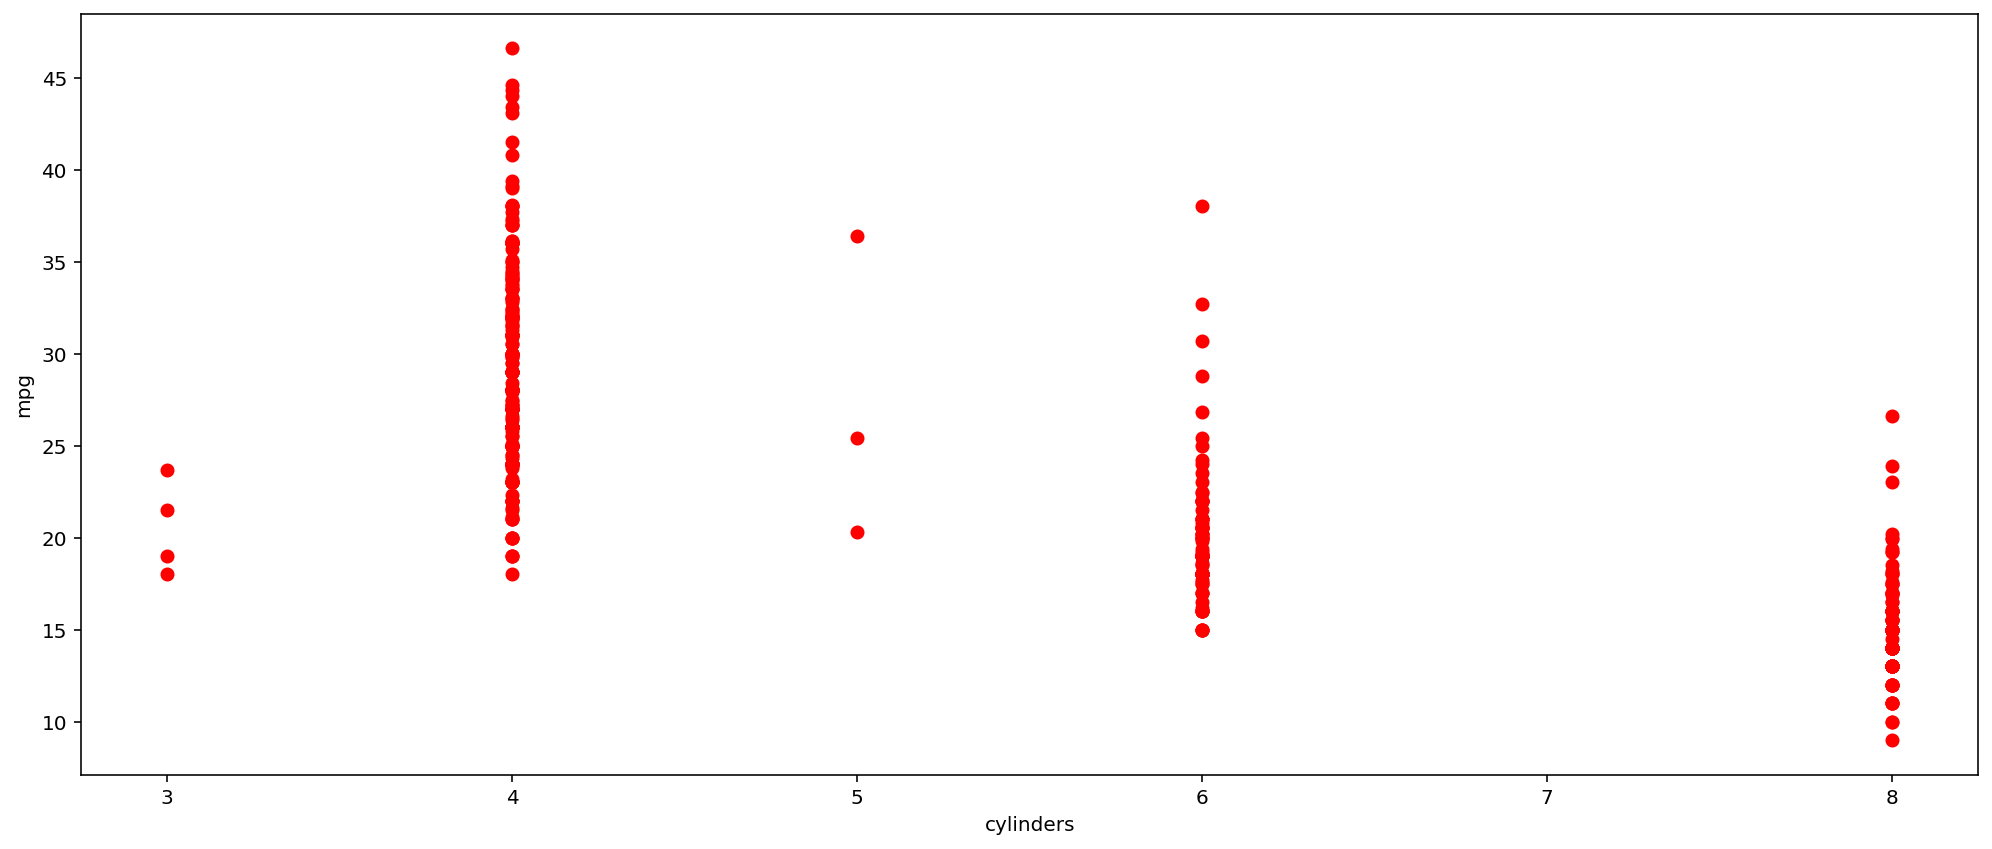

In [ ]:

plt.plot(df_auto['cylinders'], df_auto['mpg'], "bo", color='red')
plt.ylabel('mpg')
plt.xlabel('cylinders')

In [ ]:
x_train_ori.describe()

x_train_we_ho_di = x_train_ori[['weight','horsepower', 'displacement']]
#x_train_we_ho_di.describe()
model_rl_we_ho_di = LinearRegression()
model_rl_we_ho_di.fit(x_train_we_ho_di, y_train)

imprimir_datos_modelo(model_rl_we_ho_di, x_train_we_ho_di, x_train_we_ho_di, y_train)

w_0 44.85593569526507
[-0.005351592611033897, -0.04167414380111989, -0.005768818707611742]
R^2 (A) 0.7069554693444708
R^2 (B) 0.7069554693444708
Error cuadrático medio: 17.8062
Error absoluto medio 3.2310140863101817
Mediana del error absoluto 2.595340451771614
Error Cuadrático Medio = 4.219737926479923


In [ ]:
#Ejemplos de Obtención de estimaciones
x_ejem_1 = np.array([[3500, 77, 100]] )
print('Ejemplo Estimacion (1):', model_rl_we_ho_di.predict( x_ejem_1 ))

x_ejem_2 = np.array([[3200, 110, 180]] )
print('Ejemplo Estimacion (2):', model_rl_we_ho_di.predict( x_ejem_2 ))


x_ejem = np.concatenate( (x_ejem_1, x_ejem_2 ) )


Ejemplo Estimacion (1): [22.33957061]
Ejemplo Estimacion (2): [22.10829615]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
########################################################
###### Diviendo el DataSet #############################
########################################################

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


df_auto.describe()

X=df_auto[['weight','horsepower', 'displacement']]
#X.describe()

Y=df_auto[['mpg']]
#Y.describe()

x_train, x_test, y_train, y_test = train_test_split(
                                        X.values#.reshape(-1,1)
                                        , Y.values#.reshape(-1,1)
                                        , train_size   = 0.80
                                        , random_state = 100   # 1234 :::: divide datos seleccionados al azar pero con un giro. Y el giro es que el orden de los datos será el mismo para un valor particular de random_state :: Para que se desordenan antes de divir los registros # los resultados producidos serán los mismos de siempre. Esto ayuda a verificar la salida
                                        , shuffle      = True   # Para que un valor de una clase no se concentre en 1 de los 2 dataset
                                    )

print("x_train %s :: y_train %s :: x_test %s :: y_test %s" %( str(x_train.shape), str(y_train.shape), str(x_test.shape), str(y_test.shape) ) )




x_train (313, 3) :: y_train (313, 1) :: x_test (79, 3) :: y_test (79, 1)


In [ ]:
modelo_rl_we_ho_dis = LinearRegression()
modelo_rl_we_ho_dis.fit(X = x_train, y = y_train)


imprimir_datos_modelo(modelo_rl_we_ho_dis, X, x_train, y_train)

w_0 [45.06958713]
[[-0.005067991293286907, -0.0481739561141432, -0.006820767863508]]
R^2 (A) 0.7002221165244834
R^2 (B) 0.7002221165244834
Error cuadrático medio: 18.9623
Error absoluto medio 3.3421401413656504
Mediana del error absoluto 2.6870041659688226
Error Cuadrático Medio = 4.3545705571668805


In [ ]:
predicciones = modelo_rl_we_ho_dis.predict(X = x_test)
print(predicciones[0:5,])

[[23.42164027]
 [31.3546245 ]
 [30.95688523]
 [24.5840531 ]
 [24.37512826]]


In [ ]:
imprimir_datos_modelo(modelo_rl_we_ho_dis, X, x_test, y_test)

w_0 [45.06958713]
[[-0.005067991293286907, -0.0481739561141432, -0.006820767863508]]
R^2 (A) 0.7245669039698086
R^2 (B) 0.7245669039698086
Error cuadrático medio: 13.5178
Error absoluto medio 2.960353515976223
Mediana del error absoluto 2.9138521243543956
Error Cuadrático Medio = 3.6766582527278886


In [ ]:
##################################################################################
#El mismo ejemplo de Obtención de estimaciones SIN DIVIDIR EL DATASET ORIGINAL
#################################################################################

x_ejem_1 = np.array([[3500, 77, 100]] )
print('Ejemplo Estimacion (1):', modelo_rl_we_ho_dis.predict( x_ejem_1 ))

x_ejem_2 = np.array([[3200, 110, 180]] )
print('Ejemplo Estimacion (2):', modelo_rl_we_ho_dis.predict( x_ejem_2 ))

x_ejem = np.concatenate( (x_ejem_1, x_ejem_2 ) )


Ejemplo Estimacion (1): [[22.94014619]]
Ejemplo Estimacion (2): [[22.3251416]]


**Validacion Cruzada :: REF con todas las variables Independientes**

In [ ]:
df_auto.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531,23.445918
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518,7.805007
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,17.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,22.750000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [ ]:
#######################################################################################
###### Validacion Cruzada :: RFE "N" caracteristicas Elegidas ############################
########################################################################################

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


df_auto.describe()

#print(len(df_auto.columns))
print("====================x_train===============================")
X = df_auto.iloc[:, :(len(df_auto.columns)-1)]
print(X.shape)
X.info(verbose = False)
#print(X)

print("====================y_train===============================")
Y = df_auto.iloc[:,-1]
print(Y.shape)
Y.head()
print(Y)

x_train, x_test, y_train, y_test = train_test_split(
                                        X.values#.reshape(-1,1)
                                        , Y.values#.reshape(-1,1)
                                        , train_size   = 0.80
                                        , random_state = 100   # 1234 :::: divide datos seleccionados al azar pero con un giro. Y el giro es que el orden de los datos será el mismo para un valor particular de random_state :: Para que se desordenan antes de divir los registros # los resultados producidos serán los mismos de siempre. Esto ayuda a verificar la salida
                                        , shuffle      = True   # Para que un valor de una clase no se concentre en 1 de los 2 dataset
                                    )

print("x_train %s :: y_train %s :: x_test %s :: y_test %s" %( str(x_train.shape), str(y_train.shape), str(x_test.shape), str(y_test.shape) ) )




====================x_train===============================
(392, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Columns: 7 entries, cylinders to origin
dtypes: float64(4), int64(3)
memory usage: 21.6 KB
====================y_train===============================
(392,)
0      18.0
1      15.0
2      18.0
3      16.0
4      17.0
       ... 
387    27.0
388    44.0
389    32.0
390    28.0
391    31.0
Name: mpg, Length: 392, dtype: float64
x_train (313, 7) :: y_train (313,) :: x_test (79, 7) :: y_test (79,)


In [ ]:
from sklearn.feature_selection import RFE  #Recursiva Eliminacion de Caracteristicas :: Es un método de selección de características que se ajusta a un modelo y elimina la característica (o características) más débil (o características) hasta que se alcanza el número especificado de características
val_column = x_train.shape[1] + 1


modelo_rl_rfe = LinearRegression()
modelo_rl_rfe.fit(x_train, y_train)


rfe = RFE(LinearRegression(), n_features_to_select=3)
rfe = rfe.fit(x_train, y_train)

list(zip(X.columns,rfe.support_,rfe.ranking_))




[('cylinders', True, 1),
 ('displacement', False, 4),
 ('horsepower', False, 3),
 ('weight', False, 5),
 ('acceleration', False, 2),
 ('model_year', True, 1),
 ('origin', True, 1)]

In [ ]:
# predict prices of X_test
y_test_pred = rfe.predict(x_test)

print("n_features_to_select=3 :: cylinders, model_year, origin")
imprimir_datos_modelo_CV(rfe, X, x_test, y_test)

n_features_to_select=3 :: cylinders, model_year, origin
R^2 (A) 0.7208495548920236
R^2 (B) 0.7208495548920236
Error cuadrático medio: 13.7003
Error absoluto medio 3.015390686820022
Mediana del error absoluto 2.8480597565331784
Error Cuadrático Medio = 3.701385883107407





Entrenar mi Modelo con 3 las variables que me recomienda pearson 'acceleration', 'model_year', 'origin'

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


df_auto.describe()
#X=df_auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
X=df_auto[['acceleration', 'model_year', 'origin']]
#X.describe()
Y=df_auto[['mpg']]
#Y.describe()
x_train, x_test, y_train, y_test = train_test_split(
                                        X.values#.reshape(-1,1)
                                        , Y.values#.reshape(-1,1)
                                        , train_size   = 0.80
                                        , random_state = 100   # 1234 :::: divide datos seleccionados al azar pero con un giro. Y el giro es que el orden de los datos será el mismo para un valor particular de random_state :: Para que se desordenan antes de divir los registros # los resultados producidos serán los mismos de siempre. Esto ayuda a verificar la salida
                                        , shuffle      = True   # Para que un valor de una clase no se concentre en 1 de los 2 dataset
                                    )

print("x_train %s :: y_train %s :: x_test %s :: y_test %s" %( str(x_train.shape), str(y_train.shape), str(x_test.shape), str(y_test.shape) ) )



x_train (313, 3) :: y_train (313, 1) :: x_test (79, 3) :: y_test (79, 1)


In [ ]:

modelo_rl_cy_my_or = LinearRegression()
modelo_rl_cy_my_or.fit(X = x_train, y = y_train)

imprimir_datos_modelo(modelo_rl_cy_my_or, X, x_train, y_train)


y_test_pred = modelo_rl_cy_my_or.predict(x_test)
imprimir_datos_modelo(modelo_rl_cy_my_or, X, x_test, y_test)

w_0 [-63.12569447]
[[0.6471572983109982, 0.9226068439170818, 4.1738722929746706]]
R^2 (A) 0.6124911322932688
R^2 (B) 0.6124911322932688
Error cuadrático medio: 24.5117
Error absoluto medio 3.995263745890334
Mediana del error absoluto 3.4448412564845086
Error Cuadrático Medio = 4.950925143303865



w_0 [-63.12569447]
[[0.6471572983109982, 0.9226068439170818, 4.1738722929746706]]
R^2 (A) 0.4624272570307991
R^2 (B) 0.4624272570307991
Error cuadrático medio: 26.3832
Error absoluto medio 4.4013531446538785
Mediana del error absoluto 4.0473087998677215
Error Cuadrático Medio = 5.136458954464584





Entrenar mi Modelo con 3 las variables que me recomienda RIF 'cylinders', 'model_year', 'origin'

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


df_auto.describe()
#X=df_auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
X=df_auto[['cylinders', 'model_year', 'origin']]
#X.describe()
Y=df_auto[['mpg']]
#Y.describe()
x_train, x_test, y_train, y_test = train_test_split(
                                        X.values#.reshape(-1,1)
                                        , Y.values#.reshape(-1,1)
                                        , train_size   = 0.80
                                        , random_state = 100   # 1234 :::: divide datos seleccionados al azar pero con un giro. Y el giro es que el orden de los datos será el mismo para un valor particular de random_state :: Para que se desordenan antes de divir los registros # los resultados producidos serán los mismos de siempre. Esto ayuda a verificar la salida
                                        , shuffle      = True   # Para que un valor de una clase no se concentre en 1 de los 2 dataset
                                    )

print("x_train %s :: y_train %s :: x_test %s :: y_test %s" %( str(x_train.shape), str(y_train.shape), str(x_test.shape), str(y_test.shape) ) )


x_train (313, 3) :: y_train (313, 1) :: x_test (79, 3) :: y_test (79, 1)


In [ ]:
modelo_rl_cy_my_or = LinearRegression()
modelo_rl_cy_my_or.fit(X = x_train, y = y_train)

imprimir_datos_modelo(modelo_rl_cy_my_or, X, x_train, y_train)


y_test_pred = modelo_rl_cy_my_or.predict(x_test)
imprimir_datos_modelo(modelo_rl_cy_my_or, X, x_test, y_test)

w_0 [-24.70947301]
[[-2.4453497116318967, 0.7710386161848521, 1.941383749504194]]
R^2 (A) 0.7407215432359615
R^2 (B) 0.7407215432359615
Error cuadrático medio: 16.4005
Error absoluto medio 3.0274670880692245
Mediana del error absoluto 2.358183821372503
Error Cuadrático Medio = 4.049755033330165



w_0 [-24.70947301]
[[-2.4453497116318967, 0.7710386161848521, 1.941383749504194]]
R^2 (A) 0.7208495548920236
R^2 (B) 0.7208495548920236
Error cuadrático medio: 13.7003
Error absoluto medio 3.015390686820022
Mediana del error absoluto 2.8480597565331784
Error Cuadrático Medio = 3.701385883107407





**VALIDACIÓN CRUZADA PARA BUSCAR LA CANTIDAD DE VARIABLES INDEPENDIENTES**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


df_auto.describe()
X=df_auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
#X=df_auto[['cylinders', 'model_year', 'origin']]
#X.describe()
Y=df_auto[['mpg']]
#Y.describe()
x_train, x_test, y_train, y_test = train_test_split(
                                        X.values#.reshape(-1,1)
                                        , Y.values#.reshape(-1,1)
                                        , train_size   = 0.80
                                        , random_state = 100   # 1234 :::: divide datos seleccionados al azar pero con un giro. Y el giro es que el orden de los datos será el mismo para un valor particular de random_state :: Para que se desordenan antes de divir los registros # los resultados producidos serán los mismos de siempre. Esto ayuda a verificar la salida
                                        , shuffle      = True   # Para que un valor de una clase no se concentre en 1 de los 2 dataset
                                    )

print("x_train %s :: y_train %s :: x_test %s :: y_test %s" %( str(x_train.shape), str(y_train.shape), str(x_test.shape), str(y_test.shape) ) )

x_train (313, 7) :: y_train (313, 1) :: x_test (79, 7) :: y_test (79, 1)


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE  #Recursiva Eliminacion de Caracteristicas :: Es un método de selección de características que se ajusta a un modelo y elimina la característica (o características) más débil (o características) hasta que se alcanza el número especificado de características

# create a KFold object with 5 splits 
folds = KFold(n_splits = 7, shuffle = True, random_state = 100)
scores  = cross_val_score(LinearRegression(), x_train, y_train, scoring='r2', cv=folds) #Evaluamos cada subconjunto por la metrica de R2
print(scores)

# step-2: specify range of hyperparameters to tune
val_column = x_train.shape[1] + 1
#print(val_column)
hyper_params = [{'n_features_to_select': list(range(1, val_column))}]

# 3.1 specify model
modelo_rl_all_columns = LinearRegression()
modelo_rl_all_columns.fit(x_train, y_train)
imprimir_datos_modelo_CV(modelo_rl_all_columns, X, x_train, y_train)


[0.82318285 0.80047528 0.74262533 0.78998041 0.80314112 0.82214841
 0.84417783]
R^2 (A) 0.8224190792449326
R^2 (B) 0.8224190792449326
Error cuadrático medio: 11.2328
Error absoluto medio 2.5212049061575854
Mediana del error absoluto 1.958185402054763
Error Cuadrático Medio = 3.351534459542141





In [ ]:
rfe = RFE(modelo_rl_all_columns)  

modelo_rl_all_columns_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
modelo_rl_all_columns_cv.fit(x_train, y_train) 

Fitting 7 folds for each of 7 candidates, totalling 49 fits


GridSearchCV(cv=KFold(n_splits=7, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7]}],
             return_train_score=True, scoring='r2', verbose=1)

In [ ]:
cv_results = pd.DataFrame(modelo_rl_all_columns_cv.cv_results_)

cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,mean_train_score,std_train_score
0,0.005537,0.001654,0.000509,0.000100,1,{'n_features_to_select': 1},0.608900,0.715823,0.522499,0.616051,...,7,0.593153,0.580371,0.606523,0.588735,0.576915,0.619355,0.613197,0.596893,0.015193
1,0.003965,0.000136,0.000447,0.000024,2,{'n_features_to_select': 2},0.662260,0.719383,0.542582,0.639884,...,6,0.617841,0.613409,0.638479,0.619764,0.619322,0.640214,0.638813,0.626835,0.010861
2,0.003308,0.000019,0.000435,0.000016,3,{'n_features_to_select': 3},0.752450,0.704019,0.687155,0.753920,...,4,0.737588,0.744533,0.748172,0.735606,0.736656,0.741282,0.744280,0.741160,0.004378
3,0.002768,0.000067,0.000418,0.000007,4,{'n_features_to_select': 4},0.753978,0.689163,0.678066,0.749831,...,5,0.737747,0.746490,0.749936,0.736689,0.737234,0.741775,0.744619,0.742070,0.004766
4,0.002147,0.000018,0.000426,0.000017,5,{'n_features_to_select': 5},0.792713,0.761039,0.711435,0.797632,...,2,0.778021,0.782136,0.791161,0.775754,0.783585,0.783641,0.779564,0.781980,0.004628
5,0.001538,0.000022,0.000426,0.000014,6,{'n_features_to_select': 6},0.789688,0.744058,0.711156,0.799424,...,3,0.779033,0.784107,0.791162,0.775891,0.784256,0.784340,0.779700,0.782641,0.004590
6,0.001130,0.000268,0.000989,0.001074,7,{'n_features_to_select': 7},0.823183,0.800475,0.742625,0.789980,...,1,0.821825,0.823590,0.833013,0.824918,0.823117,0.819111,0.819459,0.823576,0.004326


In [ ]:
print(cv_results.params,cv_results.mean_train_score, cv_results.mean_test_score)

0    {'n_features_to_select': 1}
1    {'n_features_to_select': 2}
2    {'n_features_to_select': 3}
3    {'n_features_to_select': 4}
4    {'n_features_to_select': 5}
5    {'n_features_to_select': 6}
6    {'n_features_to_select': 7}
Name: params, dtype: object 0    0.596893
1    0.626835
2    0.741160
3    0.742070
4    0.781980
5    0.782641
6    0.823576
Name: mean_train_score, dtype: float64 0    0.584458
1    0.610070
2    0.726275
3    0.721070
4    0.763275
5    0.760461
6    0.803676
Name: mean_test_score, dtype: float64


Se ha saturada(llegado a su limite) con las todas las 7 Variables Independientes ??


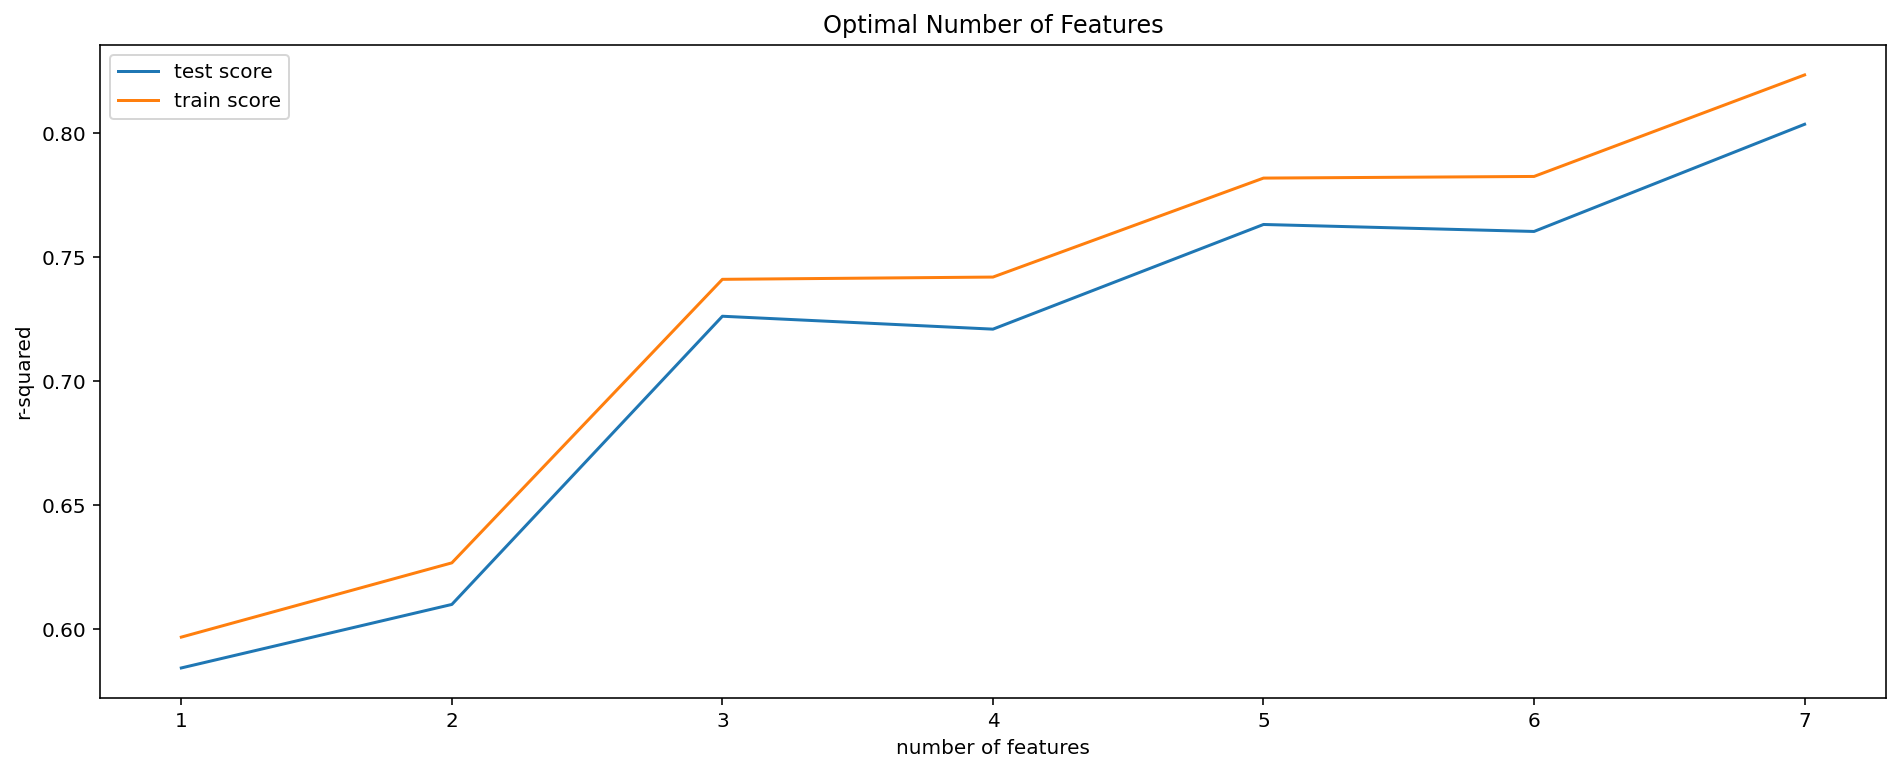

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

print("Se ha saturada(llegado a su limite) con las todas las 7 Variables Independientes ??")

In [ ]:
# final model
n_features_optimal = 7

lm = LinearRegression()
lm.fit(x_train, y_train)
imprimir_datos_modelo(lm, X, x_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(x_train, y_train)

imprimir_datos_modelo_CV(rfe, X, x_train, y_train)

# predict prices of X_test
y_pred = lm.predict(x_test)

imprimir_datos_modelo(lm, X, x_test, y_test)


w_0 [-18.78748534]
[[-0.29264961841864573, 0.018439051663712926, -0.025648856298147654, -0.00624971008536262, 0.08614171460254087, 0.7614866872752134, 1.5638251136452055]]
R^2 (A) 0.8224190792449326
R^2 (B) 0.8224190792449326
Error cuadrático medio: 11.2328
Error absoluto medio 2.5212049061575854
Mediana del error absoluto 1.958185402054763
Error Cuadrático Medio = 3.351534459542141



R^2 (A) 0.8224190792449325
R^2 (B) 0.8224190792449325
Error cuadrático medio: 11.2328
Error absoluto medio 2.5212049061575863
Mediana del error absoluto 1.958185402054763
Error Cuadrático Medio = 3.3515344595421417



w_0 [-18.78748534]
[[-0.29264961841864573, 0.018439051663712926, -0.025648856298147654, -0.00624971008536262, 0.08614171460254087, 0.7614866872752134, 1.5638251136452055]]
R^2 (A) 0.8037809643876376
R^2 (B) 0.8037809643876376
Error cuadrático medio: 9.6301
Error absoluto medio 2.5216482506427425
Mediana del error absoluto 2.1579618955512068
Error Cuadrático Medio = 3.103242899526809





**FIN FIN FIN FIN FIN FIN FIN FIN FIN FIN  FIN FIN FIN FIN FIN  FIN FIN FIN FIN FIN FIN FIN FIN FIN FIN FIN FIN FIN FIN FIN **

Con las 3 Variables Independientes de Pearson que tenian parametros positivos